# 1행1유저 변환

### ability
- 보스 키워드 포함 프리셋 선택

In [ ]:
import pandas as pd

# ability 파일 로드
ability = pd.read_csv('/content/drive/MyDrive/data/merged/ability_merged.csv')

# 레전드리 > 유니크 등급만 필터
ability = ability[ability['preset_grade'].isin(['레전드리', '유니크'])].copy()

# 기준 컬럼
group_keys = ['nickname', 'world', 'level', 'job_group', 'job', 'subclass']

# 우선순위 매기기 (레전드리 > 유니크)
grade_priority = {'레전드리': 1, '유니크': 2}
ability['grade_priority'] = ability['ability_grade'].map(grade_priority)

# 1. 보공 키워드 포함된 데이터
boss_keyword = '보스 몬스터 공격 시 데미지'
has_boss = ability['ability_value'].str.contains(boss_keyword, na=False)

# 2. 보공이 포함된 preset만 골라냄
boss_preset = (
    ability[has_boss]
    .sort_values(group_keys + ['grade_priority'])
    .drop_duplicates(subset=group_keys, keep='first')
)

# 3. 보공이 있는 경우: 그 preset만 유지
keep_presets_boss = boss_preset[group_keys + ['preset_number']]

# 4. 보공이 아예 없는 유저 찾기
all_users = ability[group_keys].drop_duplicates()
users_with_boss = keep_presets_boss[group_keys].drop_duplicates()

# 보공 없는 유저
no_boss_users = pd.merge(all_users, users_with_boss, on=group_keys, how='left', indicator=True)
no_boss_users = no_boss_users[no_boss_users['_merge'] == 'left_only'].drop(columns=['_merge'])

# 5. 보공 없는 유저는 preset_number == 1 만 남기기
no_boss_presets = no_boss_users.copy()
no_boss_presets['preset_number'] = 1

# 6. 보공 preset + preset1 (보공 없는 유저) 합치기
final_keep_presets = pd.concat([keep_presets_boss, no_boss_presets], ignore_index=True)

# 7. ability 데이터 필터링 (inner join 방식)
ability_filtered = pd.merge(ability, final_keep_presets, on=group_keys + ['preset_number'], how='inner')

# 임시 컬럼 삭제
ability_filtered = ability_filtered.drop(columns=['grade_priority'])

In [ ]:
ability_filtered

,nickname,world,level,job,subclass,preset_number,preset_grade,ability_no,ability_grade,ability_value,job_group
0,문제인,루나,295,칼리,칼리,1,레전드리,1,레전드리,스킬 사용 시 20% 확률로 재사용 대기시간이 미적용,도적
1,문제인,루나,295,칼리,칼리,1,레전드리,2,유니크,보스 몬스터 공격 시 데미지 10% 증가,도적
2,문제인,루나,295,칼리,칼리,1,레전드리,3,유니크,상태 이상에 걸린 대상 공격 시 데미지 8% 증가,도적
3,칼리,크로아,295,칼리,칼리,1,레전드리,1,레전드리,스킬 사용 시 20% 확률로 재사용 대기시간이 미적용,도적
4,칼리,크로아,295,칼리,칼리,1,레전드리,2,유니크,보스 몬스터 공격 시 데미지 10% 증가,도적
...,...,...,...,...,...,...,...,...,...,...,...
137836,곰탱이카이,루나,282,카이저,카이저,1,레전드리,2,유니크,버프 스킬의 지속 시간 38% 증가,전사
137837,곰탱이카이,루나,282,카이저,카이저,1,레전드리,3,유니크,상태 이상에 걸린 대상 공격 시 데미지 7% 증가,전사
137838,땅원영,챌린저스2,282,카이저,카이저,1,레전드리,1,레전드리,스킬 사용 시 20% 확률로 재사용 대기시간이 미적용,전사
137839,땅원영,챌린저스2,282,카이저,카이저,1,레전드리,3,유니크,보스 몬스터 공격 시 데미지 10% 증가,전사


In [ ]:
# ability_filtered에서 고유 nickname 수 세기
unique_nickname_count = ability_filtered['nickname'].nunique()

# 결과 출력
print(f"ability_filtered에서 고유 nickname 수: {unique_nickname_count}명")

ability_filtered에서 고유 nickname 수: 45947명


In [ ]:
# 어빌리티 변환 (ability_value 3개를 ability1~3로 변환)
ability_filtered['ability_no'] = ability_filtered.groupby(group_keys).cumcount() + 1
ability_filtered = ability_filtered[ability_filtered['ability_no'] <= 3]
ability_pivot = ability_filtered.pivot(index=group_keys, columns='ability_no', values='ability_value')
ability_pivot.columns = [f'ability{i}' for i in ability_pivot.columns]
ability_pivot = ability_pivot.reset_index()

ability_pivot

,nickname,world,level,job_group,job,subclass,ability1,ability2,ability3
0,0005,크로아,288,궁수,궁수,패스파인더,보스 몬스터 공격 시 데미지 20% 증가,상태 이상에 걸린 대상 공격 시 데미지 8% 증가,크리티컬 확률 20% 증가
1,002번출구,엘리시움,286,해적,해적,캐논마스터,보스 몬스터 공격 시 데미지 20% 증가,버프 스킬의 지속 시간 34% 증가,상태 이상에 걸린 대상 공격 시 데미지 8% 증가
2,00우,크로아,288,전사,초월자,제로,보스 몬스터 공격 시 데미지 20% 증가,공격력 21 증가,상태 이상에 걸린 대상 공격 시 데미지 7% 증가
3,00우즈키00,이노시스,276,궁수,레지스탕스,와일드헌터,보스 몬스터 공격 시 데미지 16% 증가,상태 이상에 걸린 대상 공격 시 데미지 5% 증가,크리티컬 확률 9% 증가
4,0101,크로아,277,궁수,레지스탕스,와일드헌터,보스 몬스터 공격 시 데미지 20% 증가,크리티컬 확률 16% 증가,상태 이상에 걸린 대상 공격 시 데미지 5% 증가
...,...,...,...,...,...,...,...,...,...
45942,힝짜,스카니아,292,궁수,궁수,패스파인더,스킬 사용 시 19% 확률로 재사용 대기시간이 미적용,보스 몬스터 공격 시 데미지 9% 증가,크리티컬 확률 20% 증가
45943,힝챨,루나,291,전사,레지스탕스,데몬슬레이어,스킬 사용 시 20% 확률로 재사용 대기시간이 미적용,상태 이상에 걸린 대상 공격 시 데미지 8% 증가,보스 몬스터 공격 시 데미지 10% 증가
45944,힝푸,베라,287,도적,호영,호영,"패시브 스킬 레벨이 1 증가 (액티브 혼합형, 5차, 6차 스킬 적용안됨)",상태 이상에 걸린 대상 공격 시 데미지 8% 증가,보스 몬스터 공격 시 데미지 10% 증가
45945,힝풋,오로라,286,전사,레지스탕스,데몬어벤져,스킬 사용 시 20% 확률로 재사용 대기시간이 미적용,보스 몬스터 공격 시 데미지 9% 증가,상태 이상에 걸린 대상 공격 시 데미지 7% 증가


In [ ]:
save_path = '/content/drive/MyDrive/data/organized/ability_organized.csv'

# 저장
ability_pivot.to_csv(save_path, index=False)

print(f"파일 저장 완료: {save_path}")

파일 저장 완료: /content/drive/MyDrive/data/organized/ability_organized.csv


------------------
### symbol

In [ ]:
# 파일 로드
symbol = pd.read_csv('/content/drive/MyDrive/data/organized/symbol_organized.csv')

In [ ]:
symbol

,nickname,world,level,job,subclass,symbol_name,symbol_force,symbol_level,job_group
0,시가,크로아,296,기사단,나이트워커,아케인심볼 : 소멸의 여로,220,20,도적
1,시가,크로아,296,기사단,나이트워커,아케인심볼 : 츄츄 아일랜드,220,20,도적
2,시가,크로아,296,기사단,나이트워커,아케인심볼 : 레헬른,220,20,도적
3,시가,크로아,296,기사단,나이트워커,아케인심볼 : 아르카나,220,20,도적
4,시가,크로아,296,기사단,나이트워커,아케인심볼 : 모라스,220,20,도적
...,...,...,...,...,...,...,...,...,...
554481,헤디,루나,281,해적,캡틴,어센틱심볼 : 세르니움,110,11,해적
554482,헤디,루나,281,해적,캡틴,어센틱심볼 : 아르크스,110,11,해적
554483,헤디,루나,281,해적,캡틴,어센틱심볼 : 오디움,100,10,해적
554484,헤디,루나,281,해적,캡틴,어센틱심볼 : 도원경,100,10,해적


In [ ]:
# 기준 컬럼
group_keys = ['nickname', 'world', 'level', 'job_group', 'job', 'subclass']

# 심볼 변환
symbol_pivot = symbol.pivot_table(index=group_keys, columns='symbol_name', values='symbol_level')
symbol_pivot = symbol_pivot.reset_index()

# group_keys 순서로 앞으로 정렬
symbol_pivot = symbol_pivot[group_keys + [col for col in symbol_pivot.columns if col not in group_keys]]

# 결과
symbol_pivot.head()

symbol_name,nickname,world,level,job_group,job,subclass,그랜드 어센틱심볼 : 탈라하트,아케인심볼 : 레헬른,아케인심볼 : 모라스,아케인심볼 : 소멸의 여로,아케인심볼 : 아르카나,아케인심볼 : 에스페라,아케인심볼 : 츄츄 아일랜드,어센틱심볼 : 도원경,어센틱심볼 : 세르니움,어센틱심볼 : 아르크스,어센틱심볼 : 아르테리아,어센틱심볼 : 오디움,어센틱심볼 : 카르시온
0,0005,크로아,288,궁수,궁수,패스파인더,NaN,20.0,20.0,20.0,20.0,20.0,20.0,8.0,11.0,10.0,7.0,9.0,6.0
1,002번출구,엘리시움,286,해적,해적,캐논마스터,NaN,20.0,20.0,20.0,20.0,20.0,20.0,7.0,11.0,8.0,6.0,7.0,6.0
2,00우,크로아,288,전사,초월자,제로,NaN,20.0,20.0,20.0,20.0,20.0,20.0,9.0,11.0,11.0,9.0,10.0,5.0
3,00우즈키00,이노시스,276,궁수,레지스탕스,와일드헌터,NaN,20.0,20.0,20.0,20.0,20.0,20.0,6.0,11.0,10.0,NaN,8.0,NaN
4,0101,크로아,277,궁수,레지스탕스,와일드헌터,NaN,18.0,18.0,19.0,18.0,19.0,19.0,NaN,5.0,5.0,NaN,NaN,NaN


In [ ]:
unique_nickname_count = symbol['nickname'].nunique()
print(f"총 유저: {unique_nickname_count}명")

총 유저: 45943명


In [ ]:
save_path = '/content/drive/MyDrive/data/organized/symbol_organized.csv'

# 저장
symbol_pivot.to_csv(save_path, index=False)

print(f"파일 저장 완료: {save_path}")

파일 저장 완료: /content/drive/MyDrive/data/organized/symbol_organized.csv


------------------
### hexamatrix

In [ ]:
# 파일 로드
hexamatrix = pd.read_csv('/content/drive/MyDrive/data/organized/hexamatrix_organized.csv')

In [ ]:
# 기준 컬럼
group_keys = ['nickname', 'world', 'level', 'job_group', 'job', 'subclass']
core_types = ['강화 코어', '공용 코어', '마스터리 코어', '스킬 코어']

# 튜플 생성
hexamatrix['skill_tuple'] = list(zip(hexamatrix['hexa_skill_id'], hexamatrix['hexa_core_level']))

# 각 코어 유형별로 유저-스킬 리스트 구성
core_type_dfs = []

for core in core_types:
    temp = hexamatrix[hexamatrix['hexa_core_type'] == core].copy()
    temp_grouped = temp.groupby(group_keys)['skill_tuple'].apply(list).reset_index()
    temp_grouped.rename(columns={'skill_tuple': core}, inplace=True)
    core_type_dfs.append(temp_grouped)

# 순차적으로 merge (outer join)
from functools import reduce
hexamatrix_merged = reduce(lambda left, right: pd.merge(left, right, on=group_keys, how='outer'), core_type_dfs)

hexamatrix_merged

,nickname,world,level,job_group,job,subclass,강화 코어,공용 코어,마스터리 코어,스킬 코어
0,0005,크로아,288,궁수,궁수,패스파인더,"[(얼티밋 블래스트 강화, 1), (레이븐 템페스트/이볼브 템페스트 강화, 3), ...","[(솔 야누스, 1)]","[(카디널 블래스트 VI, 9), (에디셔널 블래스트 VI, 9), (카디널 디스차...","[(포세이큰 렐릭, 4)]"
1,002번출구,엘리시움,286,해적,해적,캐논마스터,"[(빅 휴즈 기간틱 캐논볼 강화, 21), (ICBM 강화, 2), (스페셜 몽키 ...","[(솔 야누스, 10), (솔 야누스 : 새벽, 10), (솔 야누스 : 황혼, 10)]","[(캐논 버스터 VI, 19), (미니 캐논볼 VI, 10), (캐논 바주카 VI,...","[(슈퍼 캐논 익스플로젼, 9)]"
2,00우,크로아,288,전사,초월자,제로,"[(리미트 브레이크 강화, 25), (조인트 어택 강화, 10), (쉐도우 플래시 ...","[(솔 야누스, 10), (솔 야누스 : 새벽, 10), (솔 야누스 : 황혼, 10)]","[(윈드 커터 VI, 30), (윈드 스트라이크 VI, 30), (스톰 브레이크 V...","[(크로노 트리거, 20)]"
3,00우즈키00,이노시스,276,궁수,레지스탕스,와일드헌터,"[(재규어 스톰 강화, 4), (와일드 그레네이드 강화, 3), (와일드 발칸 Ty...","[(솔 야누스, 1), (솔 야누스 : 새벽, 1), (솔 야누스 : 황혼, 1)]","[(와일드 발칸 VI, 12), (클로우 컷 VI, 7), (프로보크 VI, 7),...","[(네이쳐스 빌리프, 7)]"
4,0101,크로아,277,궁수,레지스탕스,와일드헌터,NaN,"[(솔 야누스, 1), (솔 야누스 : 새벽, 1), (솔 야누스 : 황혼, 1)]","[(와일드 발칸 VI, 9), (클로우 컷 VI, 1), (프로보크 VI, 1), ...","[(네이쳐스 빌리프, 1)]"
...,...,...,...,...,...,...,...,...,...,...
45920,힝짜,스카니아,292,궁수,궁수,패스파인더,"[(얼티밋 블래스트 강화, 30), (레이븐 템페스트/이볼브 템페스트 강화, 30)...","[(솔 야누스, 30), (솔 야누스 : 새벽, 30), (솔 야누스 : 황혼, 30)]","[(카디널 블래스트 VI, 30), (에디셔널 블래스트 VI, 30), (카디널 디...","[(포세이큰 렐릭, 30)]"
45921,힝챨,루나,291,전사,레지스탕스,데몬슬레이어,"[(데몬 어웨이크닝 강화, 30), (요르문간드 강화, 30), (오르트로스 강화,...","[(솔 야누스, 30), (솔 야누스 : 새벽, 30), (솔 야누스 : 황혼, 30)]","[(데몬 임팩트 VI, 30), (데몬 슬래시 VI, 30), (데몬 익스플로젼 V...","[(나이트메어, 30)]"
45922,힝푸,베라,287,도적,호영,호영,"[(선기 : 극대 분신난무 강화, 15), (권술 : 산령소환 강화, 1), (선기...","[(솔 야누스, 20), (솔 야누스 : 새벽, 20), (솔 야누스 : 황혼, 20)]","[(멸화염 : 천 VI, 26), (지진쇄 : 지 VI, 26), (금고봉 : 인 ...","[(선기 : 파천황, 11)]"
45923,힝풋,오로라,286,전사,레지스탕스,데몬어벤져,"[(데몬 프렌지 강화, 15), (블러드 피스트 강화, 1), (디멘션 소드 강화,...","[(솔 야누스, 1), (솔 야누스 : 새벽, 1), (솔 야누스 : 황혼, 1)]","[(실드 체이싱 VI, 25), (익시드 : 엑스큐션 VI, 25), (익시드 : ...","[(레퀴엠, 9)]"


In [ ]:
save_path = '/content/drive/MyDrive/data/organized/hexamatrix_organized.csv'

# 저장
hexamatrix_merged.to_csv(save_path, index=False)

print(f"파일 저장 완료: {save_path}")

파일 저장 완료: /content/drive/MyDrive/data/organized/hexamatrix_organized.csv


------------------
### hexamatrix_stat

#### 수정전

In [ ]:
# 파일 로드
hexamatrix_stat = pd.read_csv('/content/drive/MyDrive/data/merged/hexamatrix_stat_merged.csv')

In [ ]:
hexamatrix_stat

,nickname,world,level,job,subclass,core_set,core_index,slot_id,main_stat_name,sub_stat_name_1,sub_stat_name_2,main_stat_level,sub_stat_level_1,sub_stat_level_2,stat_grade,job_group
0,시눙식,루나,297,호영,호영,main,1,0,공격력 증가,크리티컬 데...,보스 데미지 증가,5,9,6,20,도적
1,시눙식,루나,297,호영,호영,main,2,0,크리티컬 데...,공격력 증가,보스 데미지 증가,4,8,8,20,도적
2,시눙식,루나,297,호영,호영,main,3,0,보스 데미지 증가,크리티컬 데...,공격력 증가,3,10,7,20,도적
3,시눙식,루나,297,호영,호영,preset,1,0,공격력 증가,크리티컬 데...,보스 데미지 증가,5,9,6,20,도적
4,시눙식,루나,297,호영,호영,preset,1,1,공격력 증가,크리티컬 데...,보스 데미지 증가,5,9,6,20,도적
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323833,땅원영,챌린저스2,282,카이저,카이저,main,2,0,크리티컬 데...,주력 스탯 증가,공격력 증가,5,8,7,20,전사
323834,땅원영,챌린저스2,282,카이저,카이저,preset,1,0,보스 데미지 증가,공격력 증가,주력 스탯 증가,2,8,10,20,전사
323835,땅원영,챌린저스2,282,카이저,카이저,preset,1,1,보스 데미지 증가,공격력 증가,주력 스탯 증가,2,8,10,20,전사
323836,땅원영,챌린저스2,282,카이저,카이저,preset,2,0,크리티컬 데...,주력 스탯 증가,공격력 증가,5,8,7,20,전사


In [ ]:
# 기준 컬럼
user_keys = ['nickname', 'world', 'level', 'job_group', 'job', 'subclass']

# preset만 필터링
hexamatrix_preset = hexamatrix_stat[hexamatrix_stat['core_set'] == 'preset'].copy()

# 튜플로 변환
hexamatrix_preset['main_stat'] = list(zip(hexamatrix_preset['main_stat_name'], hexamatrix_preset['main_stat_level']))
hexamatrix_preset['sub_stat_1'] = list(zip(hexamatrix_preset['sub_stat_name_1'], hexamatrix_preset['sub_stat_level_1']))
hexamatrix_preset['sub_stat_2'] = list(zip(hexamatrix_preset['sub_stat_name_2'], hexamatrix_preset['sub_stat_level_2']))

# core_index별 reshape
preset_grouped = hexamatrix_preset.groupby(user_keys + ['core_index']).agg({
    'main_stat': 'first',
    'sub_stat_1': 'first',
    'sub_stat_2': 'first'
}).reset_index()

# 컬럼 이름 변환: pre1_main_stat, pre1_sub_stat_1, ...
def rename_for_preset(df):
    renamed = []
    for i in range(1, 7):
        temp = df[df['core_index'] == i].copy()
        if not temp.empty:
            temp = temp.drop(columns=['core_index'])
            temp.columns = user_keys + [
                f'pre{i}_main_stat',
                f'pre{i}_sub_stat_1',
                f'pre{i}_sub_stat_2'
            ]
            renamed.append(temp)
    return renamed

# 프리셋별 나누기 및 merge (reduce 방식)
from functools import reduce

preset_dfs = rename_for_preset(preset_grouped)
merged = reduce(lambda left, right: pd.merge(left, right, on=user_keys, how='outer'), preset_dfs)

# 중첩 여부 판단: slot_id == 1의 main_stat_name 이 결측인지 여부로 판단
slot1 = hexamatrix_preset[hexamatrix_preset['slot_id'] == 1]
slot1_check = slot1[user_keys + ['core_index', 'main_stat_name']].copy()
slot1_check['중첩여부'] = slot1_check['main_stat_name'].apply(lambda x: 'y' if pd.notna(x) else 'n')

# 유저 단위로 최대값 (하나라도 y 있으면 y)
중첩결과 = slot1_check.groupby(user_keys)['중첩여부'].max().reset_index()

# 최종 병합
final_df = pd.merge(merged, 중첩결과, on=user_keys, how='left')

final_df

,nickname,world,level,job_group,job,subclass,pre1_main_stat,pre1_sub_stat_1,pre1_sub_stat_2,pre2_main_stat,pre2_sub_stat_1,pre2_sub_stat_2,pre3_main_stat,pre3_sub_stat_1,pre3_sub_stat_2,중첩여부
0,0005,크로아,288,궁수,궁수,패스파인더,"(공격력 증가, 6)","(주력 스탯 증가, 9)","(보스 데미지 증가, 5)",NaN,NaN,NaN,NaN,NaN,NaN,n
1,002번출구,엘리시움,286,해적,해적,캐논마스터,"(크리티컬 데미지 증가, 4)","(주력 스탯 증가, 7)","(공격력 증가, 9)","(주력 스탯 증가, 7)","(크리티컬 데미지 증가, 3)","(공격력 증가, 10)",NaN,NaN,NaN,y
2,00우,크로아,288,전사,초월자,제로,"(공격력 증가, 6)","(주력 스탯 증가, 7)","(크리티컬 데미지 증가, 7)","(주력 스탯 증가, 5)","(데미지 증가, 7)","(크리티컬 데미지 증가, 8)","(크리티컬 데미지 증가, 5)","(공격력 증가, 8)","(주력 스탯 증가, 7)",y
3,00우즈키00,이노시스,276,궁수,레지스탕스,와일드헌터,"(공격력 증가, 6)","(주력 스탯 증가, 6)","(보스 데미지 증가, 8)",NaN,NaN,NaN,NaN,NaN,NaN,n
4,01077307346,루나,286,해적,해적,바이퍼,"(공격력 증가, 8)","(크리티컬 데미지 증가, 7)","(주력 스탯 증가, 5)","(크리티컬 데미지 증가, 6)","(공격력 증가, 7)","(주력 스탯 증가, 7)","(주력 스탯 증가, 5)","(크리티컬 데미지 증가, 10)","(공격력 증가, 5)",y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45388,힝짜,스카니아,292,궁수,궁수,패스파인더,"(보스 데미지 증가, 0)","(크리티컬 데미지 증가, 0)","(공격력 증가, 0)","(공격력 증가, 9)","(크리티컬 데미지 증가, 5)","(보스 데미지 증가, 6)","(데미지 증가, 2)","(보스 데미지 증가, 2)","(공격력 증가, 3)",y
45389,힝챨,루나,291,전사,레지스탕스,데몬슬레이어,"(크리티컬 데미지 증가, 7)","(공격력 증가, 8)","(주력 스탯 증가, 5)","(공격력 증가, 9)","(주력 스탯 증가, 5)","(크리티컬 데미지 증가, 6)","(주력 스탯 증가, 8)","(크리티컬 데미지 증가, 6)","(공격력 증가, 6)",y
45390,힝푸,베라,287,도적,호영,호영,"(주력 스탯 증가, 6)","(공격력 증가, 8)","(크리티컬 데미지 증가, 6)","(크리티컬 데미지 증가, 7)","(주력 스탯 증가, 8)","(공격력 증가, 5)",NaN,NaN,NaN,y
45391,힝풋,오로라,286,전사,레지스탕스,데몬어벤져,"(크리티컬 데미지 증가, 6)","(공격력 증가, 7)","(주력 스탯 증가, 7)",NaN,NaN,NaN,NaN,NaN,NaN,y


In [ ]:
save_path = '/content/drive/MyDrive/data/organized/hexamatrix_stat_organized.csv'

# 저장
final_df.to_csv(save_path, index=False)

print(f"파일 저장 완료: {save_path}")

파일 저장 완료: /content/drive/MyDrive/data/organized/hexamatrix_stat_organized.csv


#### 수정후

In [ ]:
import pandas as pd

# 파일 로드
hexamatrix_stat = pd.read_csv('/content/drive/MyDrive/data/merged/hexamatrix_stat_merged.csv')

# 기준 컬럼
user_keys = ['nickname', 'world', 'level', 'job_group', 'job', 'subclass']

# preset만 필터링
hexamatrix_preset = hexamatrix_stat[hexamatrix_stat['core_set'] == 'preset'].copy()

# 스탯 매핑
stat_mapping = {
    '크리티컬 데미지 증가': 'hexa_크리티컬 데미지',
    '보스 데미지 증가': 'hexa_보스 데미지',
    '방어율 무시 증가': 'hexa_방어율 무시',
    '데미지 증가': 'hexa_데미지',
    '공격력 증가': 'hexa_공격력/마력',
    '마력 증가': 'hexa_공격력/마력',
    '주력 스탯 증가': 'hexa_주스탯'
}

# 타겟 컬럼 정의
base_cols = list(set(stat_mapping.values()))
main_cols = [f"{col}_main" for col in base_cols]
sub_cols = [f"{col}_sub" for col in base_cols]
all_target_cols = main_cols + sub_cols

# 집계
records = []
grouped = hexamatrix_preset.groupby(user_keys)

for keys, group in grouped:
    count = dict.fromkeys(all_target_cols, 0)
    for _, row in group.iterrows():
        for prefix, name, lvl in [
            ("main", row['main_stat_name'], row['main_stat_level']),
            ("sub", row['sub_stat_name_1'], row['sub_stat_level_1']),
            ("sub", row['sub_stat_name_2'], row['sub_stat_level_2'])
        ]:
            if pd.notna(name) and pd.notna(lvl):
                mapped = stat_mapping.get(name)
                if mapped:
                    count[f"{mapped}_{prefix}"] += lvl
    record = dict(zip(user_keys, keys))
    record.update(count)
    records.append(record)

# 결과
final_df_split = pd.DataFrame(records)
final_df_split.head()

,nickname,world,level,job_group,job,subclass,hexa_데미지_main,hexa_공격력/마력_main,hexa_주스탯_main,hexa_보스 데미지_main,hexa_크리티컬 데미지_main,hexa_방어율 무시_main,hexa_데미지_sub,hexa_공격력/마력_sub,hexa_주스탯_sub,hexa_보스 데미지_sub,hexa_크리티컬 데미지_sub,hexa_방어율 무시_sub
0,0005,크로아,288,궁수,궁수,패스파인더,0,6,0,0,0,0,0,0,9,5,0,0
1,002번출구,엘리시움,286,해적,해적,캐논마스터,0,0,14,0,8,0,0,38,14,0,6,0
2,00우,크로아,288,전사,초월자,제로,0,12,10,0,10,0,14,16,28,0,30,0
3,00우즈키00,이노시스,276,궁수,레지스탕스,와일드헌터,0,6,0,0,0,0,0,0,6,8,0,0
4,010773...,루나,286,해적,해적,바이퍼,0,16,5,0,12,0,0,19,24,0,24,0


In [ ]:
hexamatrix_stat[hexamatrix_stat['nickname'] == '00우']

,nickname,world,level,job,subclass,core_set,core_index,slot_id,main_stat_name,sub_stat_name_1,sub_stat_name_2,main_stat_level,sub_stat_level_1,sub_stat_level_2,stat_grade,job_group
312621,00우,크로아,288,초월자,제로,main,1,0,공격력 증가,주력 스탯 증가,크리티컬 데...,6,7,7,20,전사
312622,00우,크로아,288,초월자,제로,main,2,0,주력 스탯 증가,데미지 증가,크리티컬 데...,5,7,8,20,전사
312623,00우,크로아,288,초월자,제로,main,3,0,크리티컬 데...,공격력 증가,주력 스탯 증가,5,8,7,20,전사
312624,00우,크로아,288,초월자,제로,preset,1,0,공격력 증가,주력 스탯 증가,크리티컬 데...,6,7,7,20,전사
312625,00우,크로아,288,초월자,제로,preset,1,1,공격력 증가,주력 스탯 증가,크리티컬 데...,6,7,7,20,전사
312626,00우,크로아,288,초월자,제로,preset,2,0,주력 스탯 증가,데미지 증가,크리티컬 데...,5,7,8,20,전사
312627,00우,크로아,288,초월자,제로,preset,2,1,주력 스탯 증가,데미지 증가,크리티컬 데...,5,7,8,20,전사
312628,00우,크로아,288,초월자,제로,preset,3,0,크리티컬 데...,공격력 증가,주력 스탯 증가,5,8,7,20,전사
312629,00우,크로아,288,초월자,제로,preset,3,1,크리티컬 데...,공격력 증가,주력 스탯 증가,5,8,7,20,전사


# **전처리**

## item_excluded

In [ ]:
# 파일 로드
ex_item = pd.read_csv('/content/drive/MyDrive/data/preprocessing/item_excluded.csv')
ex_item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44900 entries, 0 to 44899
Data columns (total 82 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   nickname                                                 44900 non-null  object 
 1   level                                                    44900 non-null  int64  
 2   subclass                                                 44900 non-null  object 
 3   union_level                                              44900 non-null  float64
 4   union_artifact_level                                     44900 non-null  float64
 5   artifact_effect_올스탯 증가                                   41000 non-null  float64
 6   artifact_effect_공격력 마력 증가                                42401 non-null  float64
 7   artifact_effect_데미지 증가                                   42868 non-null  float64
 8   artifact_effect_보스 몬스터 공격 

In [ ]:
import ast

# 1. crystal_1~8_opt1~3 컬럼 제거
crystal_cols = [f"crystal_{i}_opt{j}" for i in range(1, 9) for j in range(1, 4)]
ex_item = ex_item.drop(columns=crystal_cols)

# 2. champion_preset_1~3_badges → 'champion_badges'로 존재 여부 확인
badge_cols = [f'champion_preset_{i}_badges' for i in range(1, 4)]
champion_badge_flag = ex_item[badge_cols].apply(
    lambda row: 'Y' if row.notna().any() and row.astype(str).str.strip().any() else 'N',
    axis=1
)
ex_item = ex_item.drop(columns=badge_cols)

# 3. 'hyper_stat' 이전 컬럼만 남기기
start_idx = ex_item.columns.get_loc("hyper_stat")
ex_item = ex_item.iloc[:, :start_idx+1]

# 4. 'champion_badges' 다시 붙이기
ex_item['champion_badges'] = champion_badge_flag

# 5. float64 컬럼의 결측치는 0으로 대체
float_cols = ex_item.select_dtypes(include=['float64']).columns
ex_item[float_cols] = ex_item[float_cols].fillna(0)

# 6. hyper_stat 문자열 → dict → DataFrame 변환(파싱)
def parse_hyper_stat(row):
    try:
        parsed = ast.literal_eval(row)
        return dict(parsed)
    except Exception:
        return {}

hyper_stat_dicts = ex_item['hyper_stat'].apply(parse_hyper_stat)
hyper_stat_df = pd.DataFrame(hyper_stat_dicts.tolist())
hyper_stat_df.columns = [f'hyper_{col}' for col in hyper_stat_df.columns]

# 기존 'hyper_stat' 제거하고 파싱 결과 병합
ex_item = pd.concat([ex_item.drop(columns=['hyper_stat']), hyper_stat_df], axis=1)

# 7. final_df_split 병합 (nickname, level, subclass 기준)
merge_keys = ['nickname', 'level', 'subclass']
ex_item = pd.merge(ex_item, final_df_split, on=merge_keys, how='left')

# 8. 병합 후 불필요 컬럼 제거
cols_to_drop = [
    'world', 'job_group', 'job', 'skill_name', 'set_info'
]
ex_item = ex_item.drop(columns=cols_to_drop)

# 9. 최종 결과 확인
print("처리 완료. 최종 shape:", ex_item.shape)
ex_item.head()

처리 완료. 최종 shape: (44900, 67)


,nickname,level,subclass,union_level,union_artifact_level,artifact_effect_올스탯 증가,artifact_effect_공격력 마력 증가,artifact_effect_데미지 증가,artifact_effect_보스 몬스터 공격 시 데미지 증가,artifact_effect_몬스터 방어율 무시 증가,artifact_effect_버프 지속시간 증가,artifact_effect_재사용 대기시간 미적용 확률 증가,artifact_effect_메소 획득량 증가,artifact_effect_아이템 드롭률 증가,artifact_effect_크리티컬 확률 증가,artifact_effect_크리티컬 데미지 증가,artifact_effect_추가 경험치 획득 증가 다수 공격 스킬의 최대 공격 가능 대상 수 증가,artifact_effect_파이널 어택류 스킬의 데미지 증가,artifact_effect_상태 이상 내성 증가,artifact_effect_소환수 지속시간 증가,artifact_effect_최대 HP 최대 MP 증가,ability1,ability2,ability3,그랜드 어센틱심볼 : 탈라하트,아케인심볼 : 레헬른,아케인심볼 : 모라스,아케인심볼 : 소멸의 여로,아케인심볼 : 아르카나,아케인심볼 : 에스페라,아케인심볼 : 츄츄 아일랜드,어센틱심볼 : 도원경,어센틱심볼 : 세르니움,어센틱심볼 : 아르크스,어센틱심볼 : 아르테리아,어센틱심볼 : 오디움,어센틱심볼 : 카르시온,champion_badges,hyper_STR,hyper_DEX,hyper_INT,hyper_LUK,hyper_HP,hyper_MP,hyper_DF/TF/PP,hyper_크리티컬 확률,hyper_크리티컬 데미지,hyper_방어율 무시,hyper_데미지,hyper_보스 몬스터 공격 시 데미지 증가,hyper_상태 이상 내성,hyper_공격력/마력,hyper_획득 경험치,hyper_아케인포스,hyper_일반 몬스터 공격 시 데미지 증가,hexa_데미지_main,hexa_공격력/마력_main,hexa_주스탯_main,hexa_보스 데미지_main,hexa_크리티컬 데미지_main,hexa_방어율 무시_main,hexa_데미지_sub,hexa_공격력/마력_sub,hexa_주스탯_sub,hexa_보스 데미지_sub,hexa_크리티컬 데미지_sub,hexa_방어율 무시_sub
0,캡스,295,미하일,9493.0,55.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,보스 몬스터...,스킬 사용 ...,상태 이상에...,5.0,20.0,20.0,20.0,20.0,20.0,20.0,11.0,11.0,11.0,11.0,11.0,11.0,Y,2.0,1.0,0,0.0,0.0,0,0,0.0,14,9,14,15,0.0,6,0.0,0.0,0.0,0,6,0,0,12,0,0,16,22,0,9,0
1,쥬히,294,미하일,10727.0,56.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,스킬 사용 ...,버프 스킬의...,보스 몬스터...,9.0,20.0,20.0,20.0,20.0,20.0,20.0,11.0,11.0,11.0,11.0,11.0,11.0,Y,5.0,0.0,0,0.0,0.0,0,0,0.0,13,10,14,15,0.0,5,0.0,5.0,0.0,0,16,8,0,12,0,0,26,32,0,26,0
2,부도,294,미하일,9813.0,56.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,보스 몬스터...,크리티컬 확...,상태 이상에...,9.0,20.0,20.0,20.0,20.0,20.0,20.0,11.0,11.0,11.0,11.0,11.0,11.0,Y,6.0,2.0,0,0.0,0.0,0,0,1.0,14,10,13,15,0.0,7,0.0,0.0,0.0,0,16,0,7,14,0,0,26,0,12,25,0
3,일선에서,293,미하일,9670.0,53.0,9.0,9.0,10.0,10.0,10.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,스킬 사용 ...,보스 몬스터...,상태 이상에...,9.0,20.0,20.0,20.0,20.0,20.0,20.0,11.0,11.0,11.0,11.0,11.0,11.0,Y,4.0,0.0,0,0.0,0.0,0,0,0.0,13,12,13,15,0.0,5,0.0,0.0,0.0,0,16,10,0,14,0,0,24,0,30,26,0
4,와락,293,미하일,9505.0,55.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,보스 몬스터...,상태 이상에...,스킬 사용 ...,9.0,20.0,20.0,20.0,20.0,20.0,20.0,11.0,11.0,11.0,11.0,11.0,11.0,Y,5.0,1.0,0,0.0,0.0,0,0,0.0,14,10,13,15,0.0,7,0.0,0.0,0.0,0,14,12,0,8,0,0,27,23,0,26,0


In [ ]:
# 저장 경로 설정
save_path = '/content/drive/MyDrive/ex_item_final.csv'

# CSV로 저장
ex_item.to_csv(save_path, index=False)

print("✅ 저장 완료:", save_path)

✅ 저장 완료: /content/drive/MyDrive/ex_item_final.csv


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10)

# 파일 로드
ex_item_final = pd.read_csv('/content/drive/MyDrive/ex_item_final.csv')
ex_item_final

,nickname,level,subclass,union_level,union_artifact_level,artifact_effect_올스탯 증가,artifact_effect_공격력 마력 증가,artifact_effect_데미지 증가,artifact_effect_보스 몬스터 공격 시 데미지 증가,artifact_effect_몬스터 방어율 무시 증가,artifact_effect_버프 지속시간 증가,artifact_effect_재사용 대기시간 미적용 확률 증가,artifact_effect_메소 획득량 증가,artifact_effect_아이템 드롭률 증가,artifact_effect_크리티컬 확률 증가,artifact_effect_크리티컬 데미지 증가,artifact_effect_추가 경험치 획득 증가 다수 공격 스킬의 최대 공격 가능 대상 수 증가,artifact_effect_파이널 어택류 스킬의 데미지 증가,artifact_effect_상태 이상 내성 증가,artifact_effect_소환수 지속시간 증가,artifact_effect_최대 HP 최대 MP 증가,ability1,ability2,ability3,그랜드 어센틱심볼 : 탈라하트,아케인심볼 : 레헬른,아케인심볼 : 모라스,아케인심볼 : 소멸의 여로,아케인심볼 : 아르카나,아케인심볼 : 에스페라,아케인심볼 : 츄츄 아일랜드,어센틱심볼 : 도원경,어센틱심볼 : 세르니움,어센틱심볼 : 아르크스,어센틱심볼 : 아르테리아,어센틱심볼 : 오디움,어센틱심볼 : 카르시온,champion_badges,hyper_STR,hyper_DEX,hyper_INT,hyper_LUK,hyper_HP,hyper_MP,hyper_DF/TF/PP,hyper_크리티컬 확률,hyper_크리티컬 데미지,hyper_방어율 무시,hyper_데미지,hyper_보스 몬스터 공격 시 데미지 증가,hyper_상태 이상 내성,hyper_공격력/마력,hyper_획득 경험치,hyper_아케인포스,hyper_일반 몬스터 공격 시 데미지 증가,hexa_데미지_main,hexa_공격력/마력_main,hexa_주스탯_main,hexa_보스 데미지_main,hexa_크리티컬 데미지_main,hexa_방어율 무시_main,hexa_데미지_sub,hexa_공격력/마력_sub,hexa_주스탯_sub,hexa_보스 데미지_sub,hexa_크리티컬 데미지_sub,hexa_방어율 무시_sub
0,캡스,295,미하일,9493.0,55.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,보스 몬스터...,스킬 사용 ...,상태 이상에...,5.0,20.0,20.0,20.0,20.0,20.0,20.0,11.0,11.0,11.0,11.0,11.0,11.0,Y,2.0,1.0,0,0.0,0.0,0,0,0.0,14,9,14,15,0.0,6,0.0,0.0,0.0,0,6,0,0,12,0,0,16,22,0,9,0
1,쥬히,294,미하일,10727.0,56.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,스킬 사용 ...,버프 스킬의...,보스 몬스터...,9.0,20.0,20.0,20.0,20.0,20.0,20.0,11.0,11.0,11.0,11.0,11.0,11.0,Y,5.0,0.0,0,0.0,0.0,0,0,0.0,13,10,14,15,0.0,5,0.0,5.0,0.0,0,16,8,0,12,0,0,26,32,0,26,0
2,부도,294,미하일,9813.0,56.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,보스 몬스터...,크리티컬 확...,상태 이상에...,9.0,20.0,20.0,20.0,20.0,20.0,20.0,11.0,11.0,11.0,11.0,11.0,11.0,Y,6.0,2.0,0,0.0,0.0,0,0,1.0,14,10,13,15,0.0,7,0.0,0.0,0.0,0,16,0,7,14,0,0,26,0,12,25,0
3,일선에서,293,미하일,9670.0,53.0,9.0,9.0,10.0,10.0,10.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,스킬 사용 ...,보스 몬스터...,상태 이상에...,9.0,20.0,20.0,20.0,20.0,20.0,20.0,11.0,11.0,11.0,11.0,11.0,11.0,Y,4.0,0.0,0,0.0,0.0,0,0,0.0,13,12,13,15,0.0,5,0.0,0.0,0.0,0,16,10,0,14,0,0,24,0,30,26,0
4,와락,293,미하일,9505.0,55.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,보스 몬스터...,상태 이상에...,스킬 사용 ...,9.0,20.0,20.0,20.0,20.0,20.0,20.0,11.0,11.0,11.0,11.0,11.0,11.0,Y,5.0,1.0,0,0.0,0.0,0,0,0.0,14,10,13,15,0.0,7,0.0,0.0,0.0,0,14,12,0,8,0,0,27,23,0,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44895,김깜몬,282,루미너스,8797.0,46.0,10.0,10.0,10.0,10.0,10.0,4.0,0.0,10.0,10.0,10.0,10.0,4.0,0.0,4.0,0.0,0.0,보스 몬스터...,상태 이상에...,버프 스킬의...,0.0,20.0,20.0,20.0,20.0,20.0,20.0,5.0,7.0,6.0,5.0,6.0,0.0,N,0.0,0.0,5,3.0,0.0,0,0,2.0,14,7,13,14,0.0,7,0.0,0.0,0.0,0,0,0,0,7,0,0,6,0,7,0,0
44896,트리트민,282,루미너스,8799.0,45.0,10.0,10.0,10.0,10.0,10.0,4.0,0.0,10.0,10.0,10.0,10.0,4.0,0.0,4.0,0.0,0.0,버프 스킬의...,상태 이상에...,보스 몬스터...,0.0,20.0,20.0,20.0,20.0,20.0,20.0,5.0,7.0,6.0,5.0,6.0,0.0,N,0.0,0.0,5,0.0,0.0,0,0,6.0,13,10,13,14,0.0,5,0.0,0.0,0.0,0,6,0,0,0,0,0,0,6,0,8,0
44897,노른판타지,282,루미너스,8917.0,49.0,5.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0,10.0,10.0,5.0,0.0,0.0,0.0,5.0,버프 스킬의...,스킬 사용 ...,상태 이상에...,0.0,20.0,20.0,20.0,20.0,20.0,20.0,7.0,11.0,9.0,6.0,8.0,0.0,Y,0.0,0.0,10,0.0,0.0,0,0,0.0,13,10,11,13,0.0,10,0.0,0.0,0.0,0,3,0,0,0,0,0,0,0,5,6,0
44898,쑤쟐,282,루미너스,9905.0,50.0,10.0,10.0,10.0,10.0,10.0,10.0,8.0,8.0,10.0,8.0,10.0,10.0,0.0,0.0,0.0,0.0,버프 스킬의...,상태 이상에...,보스 몬스터...,0.0,20.0,20.0,20.0,20.0,20.0,20.0,4.0,7.0,5.0,4.0,5.0,0.0,Y,0.0,0.0,4,0.0,0.0,0,0,0.0,10,10,14,15,0.0,3,0.0,0.0,0.0,0,0,3,0,0,0,0,1,0,4,0,0


🧾 어빌리티 효과 고유값 37개 <br>

AP를 직접 투자한 DEX의 만큼 STR 증가

AP를 직접 투자한 INT의 만큼 LUK 증가

AP를 직접 투자한 LUK의 만큼 DEX 증가

AP를 직접 투자한 STR의 만큼 DEX 증가

DEX 증가

DEX 증가, INT 증가

DEX 증가, LUK 증가

DEX 증가, STR 증가

INT 증가

INT 증가, DEX 증가

INT 증가, LUK 증가

INT 증가, STR 증가

LUK 증가

LUK 증가, DEX 증가

LUK 증가, INT 증가

LUK 증가, STR 증가

STR 증가

STR 증가, DEX 증가

STR 증가, INT 증가

STR 증가, LUK 증가

공격력 증가

레벨마다 공격력 증가

레벨마다 마력 증가

마력 증가

메소 획득량 증가

모든 능력치 증가

방어력의 만큼 데미지 고정값 증가

버프 스킬의 지속 시간 증가

보스 몬스터 공격 시 데미지 증가

상태 이상에 걸린 대상 공격 시 데미지 증가

스킬 사용 시 확률로 재사용 대기시간이 미적용

아이템 드롭률 증가

일반 몬스터 공격 시 데미지 증가

최대 HP 증가

최대 MP 증가

크리티컬 확률 증가

패시브 스킬 레벨이 증가

—> 어빌리티를 주/특수스탯으로 분류하여 count

In [ ]:
# 특수스탯 키워드 정의
special_keywords = [
    "보스", "버프", "드롭률", "메소", "상태 이상", "재사용",
    "공격 시 데미지", "크리티컬", "고정값", "패시브", "일반 몬스터",
    "레벨마다", "모든 능력치", "공격력", "마력"
]

# 전략/기본 스탯 수치 카운트 함수
def count_ability_types(row):
    special_count = 0
    basic_count = 0
    for i in range(1, 4):
        effect = row.get(f'ability{i}')
        if pd.isna(effect):
            continue
        effect = str(effect)
        if any(keyword in effect for keyword in special_keywords):
            special_count += 1
        else:
            basic_count += 1
    return pd.Series([special_count, basic_count], index=["ability_special", "ability_basic"])

# 적용
ability_counts = ex_item_final.apply(count_ability_types, axis=1)
ex_item_final = pd.concat([ex_item_final.drop(columns=['ability1', 'ability2', 'ability3']), ability_counts], axis=1)

ex_item_final

,nickname,level,subclass,union_level,union_artifact_level,artifact_effect_올스탯 증가,artifact_effect_공격력 마력 증가,artifact_effect_데미지 증가,artifact_effect_보스 몬스터 공격 시 데미지 증가,artifact_effect_몬스터 방어율 무시 증가,artifact_effect_버프 지속시간 증가,artifact_effect_재사용 대기시간 미적용 확률 증가,artifact_effect_메소 획득량 증가,artifact_effect_아이템 드롭률 증가,artifact_effect_크리티컬 확률 증가,artifact_effect_크리티컬 데미지 증가,artifact_effect_추가 경험치 획득 증가 다수 공격 스킬의 최대 공격 가능 대상 수 증가,artifact_effect_파이널 어택류 스킬의 데미지 증가,artifact_effect_상태 이상 내성 증가,artifact_effect_소환수 지속시간 증가,artifact_effect_최대 HP 최대 MP 증가,그랜드 어센틱심볼 : 탈라하트,아케인심볼 : 레헬른,아케인심볼 : 모라스,아케인심볼 : 소멸의 여로,아케인심볼 : 아르카나,아케인심볼 : 에스페라,아케인심볼 : 츄츄 아일랜드,어센틱심볼 : 도원경,어센틱심볼 : 세르니움,어센틱심볼 : 아르크스,어센틱심볼 : 아르테리아,어센틱심볼 : 오디움,어센틱심볼 : 카르시온,champion_badges,hyper_STR,hyper_DEX,hyper_INT,hyper_LUK,hyper_HP,hyper_MP,hyper_DF/TF/PP,hyper_크리티컬 확률,hyper_크리티컬 데미지,hyper_방어율 무시,hyper_데미지,hyper_보스 몬스터 공격 시 데미지 증가,hyper_상태 이상 내성,hyper_공격력/마력,hyper_획득 경험치,hyper_아케인포스,hyper_일반 몬스터 공격 시 데미지 증가,hexa_데미지_main,hexa_공격력/마력_main,hexa_주스탯_main,hexa_보스 데미지_main,hexa_크리티컬 데미지_main,hexa_방어율 무시_main,hexa_데미지_sub,hexa_공격력/마력_sub,hexa_주스탯_sub,hexa_보스 데미지_sub,hexa_크리티컬 데미지_sub,hexa_방어율 무시_sub,ability_special,ability_basic
0,캡스,295,미하일,9493.0,55.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,5.0,20.0,20.0,20.0,20.0,20.0,20.0,11.0,11.0,11.0,11.0,11.0,11.0,Y,2.0,1.0,0,0.0,0.0,0,0,0.0,14,9,14,15,0.0,6,0.0,0.0,0.0,0,6,0,0,12,0,0,16,22,0,9,0,3,0
1,쥬히,294,미하일,10727.0,56.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,9.0,20.0,20.0,20.0,20.0,20.0,20.0,11.0,11.0,11.0,11.0,11.0,11.0,Y,5.0,0.0,0,0.0,0.0,0,0,0.0,13,10,14,15,0.0,5,0.0,5.0,0.0,0,16,8,0,12,0,0,26,32,0,26,0,3,0
2,부도,294,미하일,9813.0,56.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,9.0,20.0,20.0,20.0,20.0,20.0,20.0,11.0,11.0,11.0,11.0,11.0,11.0,Y,6.0,2.0,0,0.0,0.0,0,0,1.0,14,10,13,15,0.0,7,0.0,0.0,0.0,0,16,0,7,14,0,0,26,0,12,25,0,3,0
3,일선에서,293,미하일,9670.0,53.0,9.0,9.0,10.0,10.0,10.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,9.0,20.0,20.0,20.0,20.0,20.0,20.0,11.0,11.0,11.0,11.0,11.0,11.0,Y,4.0,0.0,0,0.0,0.0,0,0,0.0,13,12,13,15,0.0,5,0.0,0.0,0.0,0,16,10,0,14,0,0,24,0,30,26,0,3,0
4,와락,293,미하일,9505.0,55.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,9.0,20.0,20.0,20.0,20.0,20.0,20.0,11.0,11.0,11.0,11.0,11.0,11.0,Y,5.0,1.0,0,0.0,0.0,0,0,0.0,14,10,13,15,0.0,7,0.0,0.0,0.0,0,14,12,0,8,0,0,27,23,0,26,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44895,김깜몬,282,루미너스,8797.0,46.0,10.0,10.0,10.0,10.0,10.0,4.0,0.0,10.0,10.0,10.0,10.0,4.0,0.0,4.0,0.0,0.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0,5.0,7.0,6.0,5.0,6.0,0.0,N,0.0,0.0,5,3.0,0.0,0,0,2.0,14,7,13,14,0.0,7,0.0,0.0,0.0,0,0,0,0,7,0,0,6,0,7,0,0,3,0
44896,트리트민,282,루미너스,8799.0,45.0,10.0,10.0,10.0,10.0,10.0,4.0,0.0,10.0,10.0,10.0,10.0,4.0,0.0,4.0,0.0,0.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0,5.0,7.0,6.0,5.0,6.0,0.0,N,0.0,0.0,5,0.0,0.0,0,0,6.0,13,10,13,14,0.0,5,0.0,0.0,0.0,0,6,0,0,0,0,0,0,6,0,8,0,3,0
44897,노른판타지,282,루미너스,8917.0,49.0,5.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0,10.0,10.0,5.0,0.0,0.0,0.0,5.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0,7.0,11.0,9.0,6.0,8.0,0.0,Y,0.0,0.0,10,0.0,0.0,0,0,0.0,13,10,11,13,0.0,10,0.0,0.0,0.0,0,3,0,0,0,0,0,0,0,5,6,0,3,0
44898,쑤쟐,282,루미너스,9905.0,50.0,10.0,10.0,10.0,10.0,10.0,10.0,8.0,8.0,10.0,8.0,10.0,10.0,0.0,0.0,0.0,0.0,0.0,20.0,20.0,20.0,20.0,20.0,20.0,4.0,7.0,5.0,4.0,5.0,0.0,Y,0.0,0.0,4,0.0,0.0,0,0,0.0,10,10,14,15,0.0,3,0.0,0.0,0.0,0,0,3,0,0,0,0,1,0,4,0,0,3,0


In [ ]:
ex_item_final.columns.tolist()

['nickname',
 'level',
 'subclass',
 'union_level',
 'union_artifact_level',
 'artifact_effect_올스탯 증가',
 'artifact_effect_공격력 마력 증가',
 'artifact_effect_데미지 증가',
 'artifact_effect_보스 몬스터 공격 시 데미지 증가',
 'artifact_effect_몬스터 방어율 무시 증가',
 'artifact_effect_버프 지속시간 증가',
 'artifact_effect_재사용 대기시간 미적용 확률 증가',
 'artifact_effect_메소 획득량 증가',
 'artifact_effect_아이템 드롭률 증가',
 'artifact_effect_크리티컬 확률 증가',
 'artifact_effect_크리티컬 데미지 증가',
 'artifact_effect_추가 경험치 획득 증가 다수 공격 스킬의 최대 공격 가능 대상 수 증가',
 'artifact_effect_파이널 어택류 스킬의 데미지 증가',
 'artifact_effect_상태 이상 내성 증가',
 'artifact_effect_소환수 지속시간 증가',
 'artifact_effect_최대 HP 최대 MP 증가',
 '그랜드 어센틱심볼 : 탈라하트',
 '아케인심볼 : 레헬른',
 '아케인심볼 : 모라스',
 '아케인심볼 : 소멸의 여로',
 '아케인심볼 : 아르카나',
 '아케인심볼 : 에스페라',
 '아케인심볼 : 츄츄 아일랜드',
 '어센틱심볼 : 도원경',
 '어센틱심볼 : 세르니움',
 '어센틱심볼 : 아르크스',
 '어센틱심볼 : 아르테리아',
 '어센틱심볼 : 오디움',
 '어센틱심볼 : 카르시온',
 'champion_badges',
 'hyper_STR',
 'hyper_DEX',
 'hyper_INT',
 'hyper_LUK',
 'hyper_HP',
 'hyper_MP',
 'hyper_DF/TF/PP',
 'hyper_크리티컬 확률',
 'hyper_

1. 'champion_badges' 컬럼: 'Y' → 1, 'N' → 0 <br>
2. 모든 심볼 레벨을 합한 'symbol' 컬럼 생성

In [ ]:
# 1. 'champion_badges' 값을 1과 0으로 변환
ex_item_final['champion_badges'] = ex_item_final['champion_badges'].map({'Y': 1, 'N': 0})

# 2. 심볼 컬럼 합산 → 'symbol' 컬럼 생성 후 기존 심볼 컬럼 제거
symbol_cols = [
    '그랜드 어센틱심볼 : 탈라하트',
    '아케인심볼 : 레헬른',
    '아케인심볼 : 모라스',
    '아케인심볼 : 소멸의 여로',
    '아케인심볼 : 아르카나',
    '아케인심볼 : 에스페라',
    '아케인심볼 : 츄츄 아일랜드',
    '어센틱심볼 : 도원경',
    '어센틱심볼 : 세르니움',
    '어센틱심볼 : 아르크스',
    '어센틱심볼 : 아르테리아',
    '어센틱심볼 : 오디움',
    '어센틱심볼 : 카르시온'
]

# 결측치 처리 후 합산
ex_item_final['symbol_level'] = ex_item_final[symbol_cols].fillna(0).sum(axis=1)

# 기존 심볼 컬럼 제거
ex_item_final = ex_item_final.drop(columns=symbol_cols)

ex_item_final

,nickname,level,subclass,union_level,union_artifact_level,artifact_effect_올스탯 증가,artifact_effect_공격력 마력 증가,artifact_effect_데미지 증가,artifact_effect_보스 몬스터 공격 시 데미지 증가,artifact_effect_몬스터 방어율 무시 증가,artifact_effect_버프 지속시간 증가,artifact_effect_재사용 대기시간 미적용 확률 증가,artifact_effect_메소 획득량 증가,artifact_effect_아이템 드롭률 증가,artifact_effect_크리티컬 확률 증가,artifact_effect_크리티컬 데미지 증가,artifact_effect_추가 경험치 획득 증가 다수 공격 스킬의 최대 공격 가능 대상 수 증가,artifact_effect_파이널 어택류 스킬의 데미지 증가,artifact_effect_상태 이상 내성 증가,artifact_effect_소환수 지속시간 증가,artifact_effect_최대 HP 최대 MP 증가,champion_badges,hyper_STR,hyper_DEX,hyper_INT,hyper_LUK,hyper_HP,hyper_MP,hyper_DF/TF/PP,hyper_크리티컬 확률,hyper_크리티컬 데미지,hyper_방어율 무시,hyper_데미지,hyper_보스 몬스터 공격 시 데미지 증가,hyper_상태 이상 내성,hyper_공격력/마력,hyper_획득 경험치,hyper_아케인포스,hyper_일반 몬스터 공격 시 데미지 증가,hexa_데미지_main,hexa_공격력/마력_main,hexa_주스탯_main,hexa_보스 데미지_main,hexa_크리티컬 데미지_main,hexa_방어율 무시_main,hexa_데미지_sub,hexa_공격력/마력_sub,hexa_주스탯_sub,hexa_보스 데미지_sub,hexa_크리티컬 데미지_sub,hexa_방어율 무시_sub,ability_special,ability_basic,symbol_level
0,캡스,295,미하일,9493.0,55.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,1,2.0,1.0,0,0.0,0.0,0,0,0.0,14,9,14,15,0.0,6,0.0,0.0,0.0,0,6,0,0,12,0,0,16,22,0,9,0,3,0,191.0
1,쥬히,294,미하일,10727.0,56.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,1,5.0,0.0,0,0.0,0.0,0,0,0.0,13,10,14,15,0.0,5,0.0,5.0,0.0,0,16,8,0,12,0,0,26,32,0,26,0,3,0,195.0
2,부도,294,미하일,9813.0,56.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,1,6.0,2.0,0,0.0,0.0,0,0,1.0,14,10,13,15,0.0,7,0.0,0.0,0.0,0,16,0,7,14,0,0,26,0,12,25,0,3,0,195.0
3,일선에서,293,미하일,9670.0,53.0,9.0,9.0,10.0,10.0,10.0,9.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,1,4.0,0.0,0,0.0,0.0,0,0,0.0,13,12,13,15,0.0,5,0.0,0.0,0.0,0,16,10,0,14,0,0,24,0,30,26,0,3,0,195.0
4,와락,293,미하일,9505.0,55.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,0.0,0.0,0.0,1,5.0,1.0,0,0.0,0.0,0,0,0.0,14,10,13,15,0.0,7,0.0,0.0,0.0,0,14,12,0,8,0,0,27,23,0,26,0,3,0,195.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44895,김깜몬,282,루미너스,8797.0,46.0,10.0,10.0,10.0,10.0,10.0,4.0,0.0,10.0,10.0,10.0,10.0,4.0,0.0,4.0,0.0,0.0,0,0.0,0.0,5,3.0,0.0,0,0,2.0,14,7,13,14,0.0,7,0.0,0.0,0.0,0,0,0,0,7,0,0,6,0,7,0,0,3,0,149.0
44896,트리트민,282,루미너스,8799.0,45.0,10.0,10.0,10.0,10.0,10.0,4.0,0.0,10.0,10.0,10.0,10.0,4.0,0.0,4.0,0.0,0.0,0,0.0,0.0,5,0.0,0.0,0,0,6.0,13,10,13,14,0.0,5,0.0,0.0,0.0,0,6,0,0,0,0,0,0,6,0,8,0,3,0,149.0
44897,노른판타지,282,루미너스,8917.0,49.0,5.0,10.0,10.0,10.0,10.0,10.0,10.0,0.0,10.0,10.0,10.0,5.0,0.0,0.0,0.0,5.0,1,0.0,0.0,10,0.0,0.0,0,0,0.0,13,10,11,13,0.0,10,0.0,0.0,0.0,0,3,0,0,0,0,0,0,0,5,6,0,3,0,161.0
44898,쑤쟐,282,루미너스,9905.0,50.0,10.0,10.0,10.0,10.0,10.0,10.0,8.0,8.0,10.0,8.0,10.0,10.0,0.0,0.0,0.0,0.0,1,0.0,0.0,4,0.0,0.0,0,0,0.0,10,10,14,15,0.0,3,0.0,0.0,0.0,0,0,3,0,0,0,0,1,0,4,0,0,3,0,145.0


주/특수스탯으로 분류

| 요약 컬럼 이름                | 포함되는 기존 컬럼 목록                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| ----------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **artifact\_special**   | • artifact\_effect\_공격력 마력 증가  <br>• artifact\_effect\_데미지 증가  <br>• artifact\_effect\_보스 몬스터 공격 시 데미지 증가  <br>• artifact\_effect\_버프 지속시간 증가  <br>• artifact\_effect\_재사용 대기시간 미적용 확률 증가  <br>• artifact\_effect\_메소 획득량 증가  <br>• artifact\_effect\_아이템 드롭률 증가  <br>• artifact\_effect\_크리티컬 확률 증가  <br>• artifact\_effect\_크리티컬 데미지 증가  <br>• artifact\_effect\_파이널 어택류 스킬의 데미지 증가  <br>• artifact\_effect\_상태 이상 내성 증가  <br>• artifact\_effect\_올스탯 증가  <br>• artifact\_effect\_몬스터 방어율 무시 증가  <br>• artifact\_effect\_추가 경험치 획득 증가 다수 공격 스킬의 최대 공격 가능 대상 수 증가  <br>• artifact\_effect\_소환수 지속시간 증가 |
| **artifact\_basic**     | • artifact\_effect\_최대 HP 최대 MP 증가                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| **hyper\_special**      | • hyper\_DF/TF/PP  <br>• hyper\_크리티컬 확률  <br>• hyper\_크리티컬 데미지  <br>• hyper\_방어율 무시  <br>• hyper\_데미지  <br>• hyper\_보스 몬스터 공격 시 데미지 증가  <br>• hyper\_상태 이상 내성  <br>• hyper\_공격력/마력  <br>• hyper\_획득 경험치  <br>• hyper\_아케인포스  <br>• hyper\_일반 몬스터 공격 시 데미지 증가                                                                                                                                                                                                                                                                                                                                            |
| **hyper\_basic**        | • hyper\_STR  <br>• hyper\_DEX  <br>• hyper\_INT  <br>• hyper\_LUK  <br>• hyper\_HP  <br>• hyper\_MP                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| **hexa\_main\_special** | • hexa\_보스 데미지\_main  <br>• hexa\_크리티컬 데미지\_main  <br>• hexa\_공격력/마력\_main  <br>• hexa\_데미지\_main  <br>• hexa\_방어율 무시\_main                                                                                                                                                                                                                                                                                                                                                                                                                                                                             |
| **hexa\_main\_basic**   | • hexa\_주스탯\_main                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| **hexa\_sub\_special**  | • hexa\_보스 데미지\_sub  <br>• hexa\_크리티컬 데미지\_sub  <br>• hexa\_공격력/마력\_sub  <br>• hexa\_데미지\_sub  <br>• hexa\_방어율 무시\_sub                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |
| **hexa\_sub\_basic**    | • hexa\_주스탯\_sub                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |


In [ ]:
# 1. 요약 컬럼 정의
artifact_special_cols = [
    'artifact_effect_공격력 마력 증가', 'artifact_effect_데미지 증가',
    'artifact_effect_보스 몬스터 공격 시 데미지 증가', 'artifact_effect_버프 지속시간 증가',
    'artifact_effect_재사용 대기시간 미적용 확률 증가', 'artifact_effect_메소 획득량 증가',
    'artifact_effect_아이템 드롭률 증가', 'artifact_effect_크리티컬 확률 증가',
    'artifact_effect_크리티컬 데미지 증가', 'artifact_effect_파이널 어택류 스킬의 데미지 증가',
    'artifact_effect_상태 이상 내성 증가', 'artifact_effect_올스탯 증가',
    'artifact_effect_몬스터 방어율 무시 증가',
    'artifact_effect_추가 경험치 획득 증가 다수 공격 스킬의 최대 공격 가능 대상 수 증가',
    'artifact_effect_소환수 지속시간 증가'
]
artifact_basic_cols = ['artifact_effect_최대 HP 최대 MP 증가']

hyper_special_cols = [
    'hyper_DF/TF/PP', 'hyper_크리티컬 확률', 'hyper_크리티컬 데미지',
    'hyper_방어율 무시', 'hyper_데미지', 'hyper_보스 몬스터 공격 시 데미지 증가',
    'hyper_상태 이상 내성', 'hyper_공격력/마력', 'hyper_획득 경험치',
    'hyper_아케인포스', 'hyper_일반 몬스터 공격 시 데미지 증가'
]
hyper_basic_cols = [
    'hyper_STR', 'hyper_DEX', 'hyper_INT', 'hyper_LUK', 'hyper_HP', 'hyper_MP'
]

hexa_main_special_cols = [
    'hexa_보스 데미지_main', 'hexa_크리티컬 데미지_main',
    'hexa_공격력/마력_main', 'hexa_데미지_main', 'hexa_방어율 무시_main'
]
hexa_main_basic_cols = ['hexa_주스탯_main']

hexa_sub_special_cols = [
    'hexa_보스 데미지_sub', 'hexa_크리티컬 데미지_sub',
    'hexa_공격력/마력_sub', 'hexa_데미지_sub', 'hexa_방어율 무시_sub'
]
hexa_sub_basic_cols = ['hexa_주스탯_sub']

# 2. 컬럼별 합산
ex_item_final['artifact_special'] = ex_item_final[artifact_special_cols].sum(axis=1)
ex_item_final['artifact_basic']   = ex_item_final[artifact_basic_cols].sum(axis=1)

ex_item_final['hyper_special'] = ex_item_final[hyper_special_cols].sum(axis=1)
ex_item_final['hyper_basic']   = ex_item_final[hyper_basic_cols].sum(axis=1)

ex_item_final['hexa_main_special'] = ex_item_final[hexa_main_special_cols].sum(axis=1)
ex_item_final['hexa_main_basic']   = ex_item_final[hexa_main_basic_cols].sum(axis=1)

ex_item_final['hexa_sub_special'] = ex_item_final[hexa_sub_special_cols].sum(axis=1)
ex_item_final['hexa_sub_basic']   = ex_item_final[hexa_sub_basic_cols].sum(axis=1)

# 3. 기존 컬럼 제거
cols_to_drop = (
    artifact_special_cols + artifact_basic_cols +
    hyper_special_cols + hyper_basic_cols +
    hexa_main_special_cols + hexa_main_basic_cols +
    hexa_sub_special_cols + hexa_sub_basic_cols
)

ex_item_final = ex_item_final.drop(columns=cols_to_drop)
ex_item_final

,nickname,level,subclass,union_level,union_artifact_level,champion_badges,ability_special,ability_basic,symbol_level,artifact_special,artifact_basic,hyper_special,hyper_basic,hexa_main_special,hexa_main_basic,hexa_sub_special,hexa_sub_basic
0,캡스,295,미하일,9493.0,55.0,1,3,0,191.0,120.0,0.0,58.0,3.0,18,0,25,22
1,쥬히,294,미하일,10727.0,56.0,1,3,0,195.0,120.0,0.0,62.0,5.0,28,8,52,32
2,부도,294,미하일,9813.0,56.0,1,3,0,195.0,120.0,0.0,60.0,8.0,37,0,63,0
3,일선에서,293,미하일,9670.0,53.0,1,3,0,195.0,117.0,0.0,58.0,4.0,30,10,80,0
4,와락,293,미하일,9505.0,55.0,1,3,0,195.0,120.0,0.0,59.0,6.0,22,12,53,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44895,김깜몬,282,루미너스,8797.0,46.0,0,3,0,149.0,102.0,0.0,57.0,8.0,7,0,13,0
44896,트리트민,282,루미너스,8799.0,45.0,0,3,0,149.0,102.0,0.0,61.0,5.0,6,0,8,6
44897,노른판타지,282,루미너스,8917.0,49.0,1,3,0,161.0,100.0,5.0,57.0,10.0,3,0,11,0
44898,쑤쟐,282,루미너스,9905.0,50.0,1,3,0,145.0,114.0,0.0,52.0,4.0,0,3,5,0


---
## item

In [ ]:
# 파일 로드
item = pd.read_csv('/content/drive/MyDrive/data/preprocessing/item.csv')

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 10)

item.head()

,nickname,world,level,job,subclass,preset_number,equipment_part,equipment_slot,item_name,str_total,dex_total,int_total,luk_total,max_hp_total,max_mp_total,attack_power_total,magic_power_total,armor_total,speed_total,jump_total,boss_damage_total,ignore_monster_armor_total,all_stat_total,damage_total,equipment_level_decrease_total,max_hp_rate_total,max_mp_rate_total,str_base,dex_base,int_base,luk_base,max_hp_base,max_mp_base,attack_power_base,magic_power_base,armor_base,speed_base,jump_base,boss_damage_base,ignore_monster_armor_base,all_stat_base,max_hp_rate_base,max_mp_rate_base,base_equipment_level_base,potential_option_grade,additional_potential_option_grade,potential_option_1,potential_option_2,potential_option_3,additional_potential_option_1,additional_potential_option_2,additional_potential_option_3,equipment_level_increase,str_exceptional,dex_exceptional,int_exceptional,luk_exceptional,max_hp_exceptional,max_mp_exceptional,attack_power_exceptional,magic_power_exceptional,exceptional_upgrade,str_add,dex_add,int_add,luk_add,max_hp_add,max_mp_add,attack_power_add,magic_power_add,armor_add,speed_add,jump_add,boss_damage_add,damage_add,all_stat_add,equipment_level_decrease_add,str_etc,dex_etc,int_etc,luk_etc,max_hp_etc,max_mp_etc,attack_power_etc,magic_power_etc,armor_etc,speed_etc,jump_etc,starforce,starforce_scroll_flag,str_starforce,dex_starforce,int_starforce,luk_starforce,max_hp_starforce,max_mp_starforce,attack_power_starforce,magic_power_starforce,armor_starforce,speed_starforce,jump_starforce,special_ring_level,growth_exp,growth_level,scroll_upgrade,cuttable_count,golden_hammer_flag,scroll_resilience_count,scroll_upgradeable_count,soul_name,soul_option,main_stat_type,bonus_stat_total
0,별왕,크로아,296,카데나,카데나,1,모자,모자,에테르넬 시...,157,283,0,488,2125,0,137,120,2696,0,4,0,15,4,0,0,0,0,0,80,0,80,0,0,10,0,750,0,0,0,15,0,0,0,250,레전드리,레전드리,모든 스킬의...,DEX : ...,모든 스킬의...,모든 스킬의...,LUK : +7%,올스탯 : +6%,0,0,0,0,0,0,0,0,0,0.0,35,42,0,137,0,0,0,0,0,0,0,0,0,4,0,3,2,0,112,1870,0,7,0,165,0,4,22,미사용,119,159,0,159,255,0,120,120,1781,0,0,0,0,0,12,7,적용,0,0,NaN,NaN,LUK,177
1,별왕,크로아,296,카데나,카데나,1,상의,상의,에테르넬 시프셔츠,132,262,175,387,305,0,172,120,996,15,0,0,5,6,0,0,0,0,0,50,0,50,0,0,6,0,325,0,0,0,5,0,0,0,250,레전드리,레전드리,LUK : ...,LUK : ...,LUK : ...,LUK : +9%,공격력 : +15,올스탯 : +6%,0,0,0,0,0,0,0,0,0,0.0,0,35,42,149,0,0,0,0,0,0,0,0,0,6,0,13,18,14,29,50,0,46,0,10,15,0,22,미사용,119,159,119,159,255,0,120,120,661,0,0,0,0,0,8,8,적용,0,0,NaN,NaN,LUK,209
2,별왕,크로아,296,카데나,카데나,1,하의,하의,에테르넬 시프팬츠,128,275,35,371,255,0,174,120,1005,0,0,0,5,6,0,0,0,0,0,50,0,50,0,0,6,0,325,0,0,0,5,0,0,0,250,레전드리,레전드리,올스탯 : ...,LUK : ...,LUK : ...,LUK : +9%,올스탯 : +6%,공격력 : +15,0,0,0,0,0,0,0,0,0,0.0,0,49,35,144,0,0,0,0,0,0,0,0,0,6,0,9,17,0,18,0,0,48,0,13,0,0,22,미사용,119,159,0,159,255,0,120,120,667,0,0,0,0,0,8,8,적용,0,0,NaN,NaN,LUK,204
3,별왕,크로아,296,카데나,카데나,1,신발,신발,아케인셰이드...,0,223,137,373,1020,0,123,106,1013,29,29,0,0,5,0,0,0,0,0,40,0,40,0,0,9,0,250,10,7,0,0,0,0,0,200,레전드리,레전드리,LUK : ...,LUK : +9%,LUK : +9%,LUK : +8%,최대 HP ...,LUK : +6%,0,0,0,0,0,0,0,0,0,0.0,0,36,30,121,0,0,0,0,0,0,0,0,0,5,0,0,2,2,67,1020,0,8,0,91,1,4,22,미사용,0,145,105,145,0,0,106,106,672,18,18,0,0,0,8,5,적용,0,0,NaN,NaN,LUK,171
4,별왕,크로아,296,카데나,카데나,1,장갑,장갑,아케인셰이드...,116,232,0,299,0,0,175,106,786,0,14,0,0,6,0,0,0,0,0,40,0,40,0,0,9,0,250,0,0,0,0,0,0,0,200,레전드리,레전드리,크리티컬 데...,크리티컬 데...,<쓸만한 샤...,크리티컬 데...,최대 HP ...,LUK : +6%,0,0,0,0,0,0,0,0,0,0.0,0,36,0,102,0,0,5,0,0,0,0,0,0,6,0,11,11,0,12,0,0,48,0,13,0,14,22,미사용,105,145,0,145,0,0,113,106,523,0,0,0,0,0,8,5,적용,0,0,NaN,NaN,LUK,182


In [ ]:
# 컬럼 제거 리스트
cols_to_drop = [
    "growth_exp",
    "growth_level",
    "scroll_upgrade",
    "cuttable_count",
    "golden_hammer_flag",
    "scroll_resilience_count",
    "scroll_upgradeable_count",
    "soul_name",
    "soul_option",
    "special_ring_level",
    "exceptional_upgrade",
    "main_stat_type",
    "bonus_stat_total",
    "world",
    "job",
    "preset_number",
    "equipment_slot",
    "equipment_level_decrease_total",
    "base_equipment_level_base",
    "potential_option_1",
    "potential_option_2",
    "potential_option_3",
    "additional_potential_option_1",
    "additional_potential_option_2",
    "additional_potential_option_3",
    "equipment_level_increase",
    "starforce_scroll_flag"
]

item = item.drop(columns=cols_to_drop)

item.columns.tolist()

['nickname',
 'level',
 'subclass',
 'equipment_part',
 'item_name',
 'str_total',
 'dex_total',
 'int_total',
 'luk_total',
 'max_hp_total',
 'max_mp_total',
 'attack_power_total',
 'magic_power_total',
 'armor_total',
 'speed_total',
 'jump_total',
 'boss_damage_total',
 'ignore_monster_armor_total',
 'all_stat_total',
 'damage_total',
 'max_hp_rate_total',
 'max_mp_rate_total',
 'str_base',
 'dex_base',
 'int_base',
 'luk_base',
 'max_hp_base',
 'max_mp_base',
 'attack_power_base',
 'magic_power_base',
 'armor_base',
 'speed_base',
 'jump_base',
 'boss_damage_base',
 'ignore_monster_armor_base',
 'all_stat_base',
 'max_hp_rate_base',
 'max_mp_rate_base',
 'potential_option_grade',
 'additional_potential_option_grade',
 'str_exceptional',
 'dex_exceptional',
 'int_exceptional',
 'luk_exceptional',
 'max_hp_exceptional',
 'max_mp_exceptional',
 'attack_power_exceptional',
 'magic_power_exceptional',
 'str_add',
 'dex_add',
 'int_add',
 'luk_add',
 'max_hp_add',
 'max_mp_add',
 'attack

In [ ]:
# 결측치 확인
item.isna().sum().loc[lambda x: x > 0].sort_values(ascending=False)

,0
additional_potential_option_grade,205289
potential_option_grade,181615


In [ ]:
print("잠재옵션 등급 고유값:")
print(item['potential_option_grade'].unique())

print("\n에디셔널 잠재옵션 등급 고유값:")
print(item['additional_potential_option_grade'].unique())

잠재옵션 등급 고유값:
['레전드리' nan '유니크' '에픽' '레어']

에디셔널 잠재옵션 등급 고유값:
['레전드리' nan '에픽' '유니크' '레어']


In [ ]:
# 등급 매핑 딕셔너리 정의
grade_map = {
    '레어': 1,
    '에픽': 2,
    '유니크': 3,
    '레전드리': 4
}

# 두 컬럼에 매핑 적용, 결측값은 0으로 변환
item['potential_option_grade'] = item['potential_option_grade'].map(grade_map).fillna(0).astype(int)
item['additional_potential_option_grade'] = item['additional_potential_option_grade'].map(grade_map).fillna(0).astype(int)

In [ ]:
print("잠재옵션 등급 고유값:")
print(item['potential_option_grade'].unique())

print("\n에디셔널 잠재옵션 등급 고유값:")
print(item['additional_potential_option_grade'].unique())

잠재옵션 등급 고유값:
[4 0 3 2 1]

에디셔널 잠재옵션 등급 고유값:
[4 0 2 3 1]


In [ ]:
# 1. 주스탯 및 특수스탯 분류 기준 컬럼 리스트 정의

# Base
base_basic_cols = [
    'str_base', 'dex_base', 'int_base', 'luk_base',
    'max_hp_base', 'max_mp_base', 'max_hp_rate_base', 'max_mp_rate_base'
]
base_special_cols = [
    'attack_power_base', 'magic_power_base', 'armor_base', 'speed_base',
    'jump_base', 'boss_damage_base', 'ignore_monster_armor_base', 'all_stat_base'
]

# Exceptional
exceptional_basic_cols = [
    'str_exceptional', 'dex_exceptional', 'int_exceptional', 'luk_exceptional',
    'max_hp_exceptional', 'max_mp_exceptional'
]
exceptional_special_cols = ['attack_power_exceptional', 'magic_power_exceptional']

# Add
add_basic_cols = [
    'str_add', 'dex_add', 'int_add', 'luk_add', 'max_hp_add', 'max_mp_add'
]
add_special_cols = [
    'attack_power_add', 'magic_power_add', 'armor_add', 'speed_add', 'jump_add',
    'boss_damage_add', 'damage_add', 'all_stat_add'
]

# Etc
etc_basic_cols = [
    'str_etc', 'dex_etc', 'int_etc', 'luk_etc', 'max_hp_etc', 'max_mp_etc'
]
etc_special_cols = [
    'attack_power_etc', 'magic_power_etc', 'armor_etc', 'speed_etc', 'jump_etc'
]

# Starforce
star_basic_cols = [
    'str_starforce', 'dex_starforce', 'int_starforce', 'luk_starforce',
    'max_hp_starforce', 'max_mp_starforce'
]
star_special_cols = [
    'attack_power_starforce', 'magic_power_starforce', 'armor_starforce',
    'speed_starforce', 'jump_starforce'
]

# 2. 요약 컬럼 생성
item['base_basic_score'] = item[base_basic_cols].sum(axis=1)
item['base_special_score'] = item[base_special_cols].sum(axis=1)

item['exceptional_basic_score'] = item[exceptional_basic_cols].sum(axis=1)
item['exceptional_special_score'] = item[exceptional_special_cols].sum(axis=1)

item['add_basic_score'] = item[add_basic_cols].sum(axis=1)
item['add_special_score'] = item[add_special_cols].sum(axis=1)

item['etc_basic_score'] = item[etc_basic_cols].sum(axis=1)
item['etc_special_score'] = item[etc_special_cols].sum(axis=1)

item['star_basic_score'] = item[star_basic_cols].sum(axis=1)
item['star_special_score'] = item[star_special_cols].sum(axis=1)

# 3. 기존 컬럼 제거
cols_to_drop = (
    base_basic_cols + base_special_cols +
    exceptional_basic_cols + exceptional_special_cols +
    add_basic_cols + add_special_cols +
    etc_basic_cols + etc_special_cols +
    star_basic_cols + star_special_cols
)
item = item.drop(columns=cols_to_drop)

In [ ]:
item

,nickname,level,subclass,equipment_part,item_name,str_total,dex_total,int_total,luk_total,max_hp_total,max_mp_total,attack_power_total,magic_power_total,armor_total,speed_total,jump_total,boss_damage_total,ignore_monster_armor_total,all_stat_total,damage_total,max_hp_rate_total,max_mp_rate_total,potential_option_grade,additional_potential_option_grade,equipment_level_decrease_add,starforce,base_basic_score,base_special_score,exceptional_basic_score,exceptional_special_score,add_basic_score,add_special_score,etc_basic_score,etc_special_score,star_basic_score,star_special_score
0,별왕,296,카데나,모자,에테르넬 시...,157,283,0,488,2125,0,137,120,2696,0,4,0,15,4,0,0,0,4,4,0,22,160,775,0,0,214,4,1987,176,692,2021
1,별왕,296,카데나,상의,에테르넬 시프셔츠,132,262,175,387,305,0,172,120,996,15,0,0,5,6,0,0,0,4,4,0,22,100,336,0,0,226,6,124,71,811,901
2,별왕,296,카데나,하의,에테르넬 시프팬츠,128,275,35,371,255,0,174,120,1005,0,0,0,5,6,0,0,0,4,4,0,22,100,336,0,0,228,6,44,61,692,907
3,별왕,296,카데나,신발,아케인셰이드...,0,223,137,373,1020,0,123,106,1013,29,29,0,0,5,0,0,0,4,4,0,22,80,276,0,0,187,5,1091,104,395,920
4,별왕,296,카데나,장갑,아케인셰이드...,116,232,0,299,0,0,175,106,786,0,14,0,0,6,0,0,0,4,4,0,22,80,259,0,0,138,11,34,75,395,742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1063719,Prelud...,282,루미너스,포켓 아이템,핑크빛 성배,41,25,77,5,50,50,5,5,0,0,0,0,0,4,0,0,0,0,0,0,0,120,10,0,0,128,4,0,0,0,0
1063720,Prelud...,282,루미너스,기계 심장,페어리 하트,19,19,19,19,100,0,0,50,0,0,0,0,0,0,0,0,0,3,2,0,8,100,0,0,0,0,0,0,50,76,0
1063721,Prelud...,282,루미너스,뱃지,크리스탈 웬...,10,10,10,10,0,0,5,5,0,10,10,0,0,0,0,0,0,0,0,0,0,40,30,0,0,0,0,0,0,0,0
1063722,Prelud...,282,루미너스,엠블렘,골드 히어로...,10,10,10,10,0,0,2,2,0,0,0,0,0,0,0,0,0,4,3,0,0,40,4,0,0,0,0,0,0,0,0


In [ ]:
cols_to_drop = [
    "str_total",
    "dex_total",
    "int_total",
    "luk_total",
    "max_hp_total",
    "max_mp_total",
    "attack_power_total",
    "magic_power_total",
    "armor_total",
    "speed_total",
    "jump_total",
    "boss_damage_total",
    "ignore_monster_armor_total",
    "all_stat_total",
    "damage_total",
    "max_hp_rate_total",
    "max_mp_rate_total",
    "equipment_level_decrease_add",
]

item = item.drop(columns=cols_to_drop)

In [ ]:
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1063724 entries, 0 to 1063723
Data columns (total 18 columns):
 #   Column                             Non-Null Count    Dtype 
---  ------                             --------------    ----- 
 0   nickname                           1063724 non-null  object
 1   level                              1063724 non-null  int64 
 2   subclass                           1063724 non-null  object
 3   equipment_part                     1063724 non-null  object
 4   item_name                          1063724 non-null  object
 5   potential_option_grade             1063724 non-null  int64 
 6   additional_potential_option_grade  1063724 non-null  int64 
 7   starforce                          1063724 non-null  int64 
 8   base_basic_score                   1063724 non-null  int64 
 9   base_special_score                 1063724 non-null  int64 
 10  exceptional_basic_score            1063724 non-null  int64 
 11  exceptional_special_score          10

In [ ]:
# 1. 수치형 컬럼 합산: nickname 기준
value_cols = [
    'potential_option_grade', 'additional_potential_option_grade', 'starforce',
    'base_basic_score', 'base_special_score',
    'exceptional_basic_score', 'exceptional_special_score',
    'add_basic_score', 'add_special_score',
    'etc_basic_score', 'etc_special_score',
    'star_basic_score', 'star_special_score'
]

grouped_item_stats = item.groupby('nickname')[value_cols].sum().reset_index()

# 2. 세트 키워드 정의
set_keywords = {
    '루타비스': ['이글아이', '트릭스터', '하이네스', '파프니르', '루타비스'],
    '아케인': ['아케인'],
    '에테르넬': ['에테르넬', '제네시스', '데스티니'],
    '칠흑': ['루즈 컨트롤 머신 마크', '마력이 깃든 안대', '블랙 하트', '컴플리트 언더컨트롤', '몽환의 벨트',
           '고통의 근원', '창세의 뱃지', '커맨더 포스 이어링', '거대한 공포', '저주받은 마도서', '미트라의 분노'],
    '여명': ['트와일라이트 마크', '에스텔라 이어링', '데이브레이크 펜던트', '여명의 가디언 엔젤 링']
}

def classify_item_set(name):
    for set_name, keywords in set_keywords.items():
        for kw in keywords:
            if kw in str(name):
                return set_name
    return '기타'

# 3. 세트 분류 및 개수 집계
item['equipment_set'] = item['item_name'].apply(classify_item_set)
set_counts = item.groupby(['nickname', 'equipment_set']).size().unstack(fill_value=0).reset_index()

# 4. 합산 수치와 세트 개수 병합
final_df = pd.merge(grouped_item_stats, set_counts, on='nickname', how='left')

In [ ]:
final_df

,nickname,potential_option_grade,additional_potential_option_grade,starforce,base_basic_score,base_special_score,exceptional_basic_score,exceptional_special_score,add_basic_score,add_special_score,etc_basic_score,etc_special_score,star_basic_score,star_special_score,기타,루타비스,아케인,에테르넬,여명,칠흑
0,0005,34,16,54,11768,2410,0,0,5548,306,9228,557,1088,684,20,3,0,1,0,0
1,002번출구,69,44,304,5849,2928,0,0,5662,324,12384,909,7053,5200,16,3,0,1,4,0
2,00우,79,54,384,5255,4410,0,0,1744,331,8381,1326,10599,9710,13,0,0,5,2,4
3,00우즈키00,84,61,346,6407,2372,0,0,1573,266,14119,1043,8031,6985,19,3,0,0,2,0
4,0101,48,22,110,20647,2628,0,0,5485,274,11295,441,1828,1503,12,3,5,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45933,힝짜,80,80,389,6098,4930,0,0,2335,277,5536,1373,11510,12728,5,0,2,6,2,9
45934,힝챨,77,62,389,6412,3349,0,0,5959,418,8273,1092,10539,10001,9,3,0,1,2,9
45935,힝푸,75,45,296,13577,2546,0,0,1567,293,13857,987,6771,5769,16,3,0,1,4,0
45936,힝풋,68,37,188,20702,2625,0,0,27201,372,25043,656,3970,3533,19,2,0,1,1,0


---
## item_excluded + item + 전투력

In [ ]:
merged_df = pd.merge(ex_item_final, final_df, on='nickname', how='left')

In [ ]:
merged_df

,nickname,level,subclass,union_level,union_artifact_level,champion_badges,ability_special,ability_basic,symbol_level,artifact_special,artifact_basic,hyper_special,hyper_basic,hexa_main_special,hexa_main_basic,hexa_sub_special,hexa_sub_basic,potential_option_grade,additional_potential_option_grade,starforce,base_basic_score,base_special_score,exceptional_basic_score,exceptional_special_score,add_basic_score,add_special_score,etc_basic_score,etc_special_score,star_basic_score,star_special_score,기타,루타비스,아케인,에테르넬,여명,칠흑
0,캡스,295,미하일,9493.0,55.0,1,3,0,191.0,120.0,0.0,58.0,3.0,18,0,25,22,74.0,46.0,270.0,7026.0,3372.0,0.0,0.0,1507.0,309.0,11540.0,846.0,6052.0,6792.0,13.0,3.0,4.0,1.0,0.0,2.0
1,쥬히,294,미하일,10727.0,56.0,1,3,0,195.0,120.0,0.0,62.0,5.0,28,8,52,32,80.0,77.0,372.0,5414.0,3359.0,0.0,0.0,1846.0,296.0,4485.0,1004.0,10570.0,9021.0,12.0,3.0,0.0,1.0,2.0,6.0
2,부도,294,미하일,9813.0,56.0,1,3,0,195.0,120.0,0.0,60.0,8.0,37,0,63,0,80.0,80.0,386.0,8852.0,4840.0,0.0,0.0,2423.0,293.0,2440.0,1320.0,11439.0,11658.0,5.0,0.0,3.0,5.0,2.0,9.0
3,일선에서,293,미하일,9670.0,53.0,1,3,0,195.0,117.0,0.0,58.0,4.0,30,10,80,0,80.0,62.0,345.0,5238.0,2982.0,0.0,0.0,3381.0,334.0,8449.0,1212.0,8916.0,8057.0,15.0,3.0,0.0,1.0,3.0,2.0
4,와락,293,미하일,9505.0,55.0,1,3,0,195.0,120.0,0.0,59.0,6.0,22,12,53,23,78.0,72.0,373.0,5961.0,3864.0,0.0,0.0,5634.0,488.0,9589.0,1386.0,10031.0,9890.0,10.0,0.0,0.0,4.0,2.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44895,김깜몬,282,루미너스,8797.0,46.0,0,3,0,149.0,102.0,0.0,57.0,8.0,7,0,13,0,69.0,42.0,296.0,13577.0,4387.0,0.0,0.0,1789.0,400.0,2973.0,676.0,7139.0,6715.0,12.0,0.0,5.0,3.0,4.0,0.0
44896,트리트민,282,루미너스,8799.0,45.0,0,3,0,149.0,102.0,0.0,61.0,5.0,6,0,8,6,31.0,20.0,30.0,27164.0,915.0,0.0,0.0,116.0,253.0,36.0,121.0,876.0,467.0,10.0,0.0,0.0,1.0,0.0,0.0
44897,노른판타지,282,루미너스,8917.0,49.0,1,3,0,161.0,100.0,5.0,57.0,10.0,3,0,11,0,80.0,45.0,300.0,5204.0,3828.0,0.0,0.0,1579.0,366.0,5932.0,844.0,6973.0,5667.0,8.0,3.0,4.0,1.0,2.0,6.0
44898,쑤쟐,282,루미너스,9905.0,50.0,1,3,0,145.0,114.0,0.0,52.0,4.0,0,3,5,0,63.0,48.0,294.0,3805.0,3365.0,0.0,0.0,1521.0,434.0,8258.0,1198.0,6502.0,5263.0,13.0,3.0,4.0,1.0,3.0,0.0


In [ ]:
# 파일 로드
stat = pd.read_csv('/content/drive/MyDrive/data/merged/stat_merged.csv')

In [ ]:
stat

,nickname,world,level,job,subclass,최소 스탯공격력,최대 스탯공격력,데미지,보스 몬스터 데미지,최종 데미지,방어율 무시,크리티컬 확률,크리티컬 데미지,상태이상 내성,스탠스,방어력,이동속도,점프력,스타포스,아케인포스,어센틱포스,STR,DEX,INT,LUK,HP,MP,AP 배분 STR,AP 배분 DEX,AP 배분 INT,AP 배분 LUK,AP 배분 HP,AP 배분 MP,아이템 드롭률,메소 획득량,버프 지속시간,공격 속도,일반 몬스터 데미지,재사용 대기시간 감소 (초),재사용 대기시간 감소 (%),재사용 대기시간 미적용,속성 내성 무시,상태이상 추가 데미지,무기 숙련도,추가 경험치 획득,공격력,마력,전투력,소환수 지속시간 증가,job_group
0,플위,크로아,295,기사단,플레임위자드,702498...,739471...,75.0,195.0,106.25,82.61,99.0,80.95,81.0,100.0,22215.0,160.0,123.0,243.0,1320.0,740.0,2936.0,3015.0,55810.0,6482.0,45552.0,95781.0,4.0,4.0,1493.0,4.0,-434.0,-270.0,239.0,149.0,77.0,4.0,87.0,0.0,5.0,0.0,5.0,0.0,95.0,290.0,1844.0,7432.0,982538...,0.0,마법사
1,숫기,엘리시움,295,기사단,플레임위자드,171147...,178278...,186.0,386.0,110.38,96.27,105.0,143.15,71.0,100.0,29227.0,160.0,123.0,377.0,1350.0,760.0,6297.0,6025.0,67958.0,9977.0,46409.0,84572.0,4.0,4.0,1493.0,4.0,-455.0,-272.0,284.0,198.0,144.0,4.0,108.0,0.0,6.0,7.0,5.0,6.0,96.0,539.0,2700.0,8762.0,244767...,10.0,마법사
2,듄뎨,제니스,295,기사단,플레임위자드,132312...,137825...,66.0,501.0,110.38,96.54,78.0,110.45,72.0,100.0,27649.0,160.0,123.0,352.0,1350.0,750.0,7174.0,6474.0,85699.0,10048.0,40417.0,88556.0,4.0,4.0,1493.0,4.0,-440.0,-268.0,24.0,29.0,105.0,4.0,17.0,5.0,6.0,7.0,5.0,14.0,96.0,182.0,2819.0,9321.0,416525...,10.0,마법사
3,비류,스카니아,294,기사단,플레임위자드,164041...,170876...,157.0,417.0,110.38,94.76,110.0,139.80,77.0,100.0,34453.0,160.0,123.0,308.0,1350.0,760.0,7009.0,5972.0,66528.0,9125.0,41690.0,84886.0,4.0,4.0,1488.0,4.0,0.0,0.0,285.0,200.0,83.0,4.0,118.0,5.0,6.0,3.0,5.0,6.0,96.0,428.0,2732.0,9569.0,261241...,10.0,마법사
4,양씨,베라,294,기사단,플레임위자드,573433...,603614...,78.0,297.0,106.25,89.86,106.0,87.15,68.0,100.0,20301.0,160.0,123.0,259.0,1360.0,740.0,3947.0,3400.0,56035.0,7029.0,50157.0,94208.0,4.0,4.0,1488.0,4.0,-248.0,-125.0,243.0,141.0,98.0,4.0,109.0,0.0,6.0,6.0,5.0,6.0,95.0,256.0,2035.0,5927.0,109858...,12.0,마법사
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45931,심연,스카니아,286,아크,아크,116184...,129093...,69.0,398.0,55.23,92.06,71.0,107.50,84.0,100.0,99999.0,165.0,123.0,386.0,1380.0,640.0,85579.0,9355.0,5413.0,6358.0,59185.0,31124.0,1448.0,4.0,4.0,4.0,0.0,0.0,32.0,30.0,74.0,5.0,82.0,3.0,6.0,6.0,5.0,0.0,90.0,99.0,8231.0,2029.0,317181...,0.0,해적
45932,one이요,크로아,286,아크,아크,834148...,916646...,64.0,463.0,56.53,96.11,70.0,111.30,94.0,100.0,99999.0,165.0,123.0,363.0,1350.0,610.0,68079.0,10466.0,6350.0,5887.0,54812.0,30407.0,1448.0,4.0,4.0,4.0,0.0,0.0,12.0,12.0,83.0,5.0,12.0,3.0,6.0,7.0,5.0,14.0,91.0,77.0,7428.0,1617.0,254487...,10.0,해적
45933,더듀,크로아,286,아크,아크,182898...,200986...,184.0,523.0,56.53,94.87,101.0,127.50,84.0,100.0,99999.0,165.0,123.0,397.0,1350.0,640.0,82957.0,9934.0,5940.0,5886.0,76077.0,37677.0,1448.0,4.0,4.0,4.0,0.0,0.0,116.0,36.0,88.0,5.0,27.0,2.0,5.0,6.0,5.0,13.0,91.0,137.0,7782.0,2132.0,278987...,10.0,해적
45934,쀼스점,루나,286,아크,아크,539079...,592394...,64.0,300.0,56.53,89.93,100.0,99.95,86.0,100.0,97808.0,165.0,123.0,251.0,1360.0,610.0,57157.0,7743.0,3875.0,4173.0,67436.0,49789.0,1448.0,4.0,4.0,4.0,0.0,0.0,172.0,70.0,60.0,5.0,134.0,2.0,6.0,0.0,5.0,0.0,91.0,189.5,5743.0,1315.0,111145...,28.0,해적


In [ ]:
stat_power = stat[['nickname', '전투력']].copy()
stat_power

,nickname,전투력
0,플위,982538...
1,숫기,244767...
2,듄뎨,416525...
3,비류,261241...
4,양씨,109858...
...,...,...
45931,심연,317181...
45932,one이요,254487...
45933,더듀,278987...
45934,쀼스점,111145...


In [ ]:
merged_df = pd.merge(merged_df, stat_power, on='nickname', how='left')

In [ ]:
# 전투력만 NaN인 행 수
print("전투력 NaN 수:", merged_df['전투력'].isna().sum())

# 전체 NaN이 있는 행 수
print("전체 NaN이 있는 행 수:", merged_df.isna().any(axis=1).sum())

전투력 NaN 수: 59
전체 NaN이 있는 행 수: 65


In [ ]:
merged = merged_df.dropna().reset_index(drop=True)

In [ ]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44835 entries, 0 to 44834
Data columns (total 37 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   nickname                           44835 non-null  object 
 1   level                              44835 non-null  int64  
 2   subclass                           44835 non-null  object 
 3   union_level                        44835 non-null  float64
 4   union_artifact_level               44835 non-null  float64
 5   champion_badges                    44835 non-null  int64  
 6   ability_special                    44835 non-null  int64  
 7   ability_basic                      44835 non-null  int64  
 8   symbol_level                       44835 non-null  float64
 9   artifact_special                   44835 non-null  float64
 10  artifact_basic                     44835 non-null  float64
 11  hyper_special                      44835 non-null  flo

In [ ]:
# 저장 경로 설정
save_path = '/content/drive/MyDrive/merged_final.csv'

# CSV로 저장
merged.to_csv(save_path, index=False)

print("✅ 저장 완료:", save_path)

✅ 저장 완료: /content/drive/MyDrive/merged_final.csv


#### 전처리 파일 불러오기

In [ ]:
import pandas as pd

merged = pd.read_csv('/content/drive/MyDrive/merged_final.csv')

# **모델링**

## 클러스터링

### KMeans

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1. 수치형 컬럼 선택 (nickname, subclass 등 제외)
drop_cols = ['nickname', 'subclass']
numeric_cols = merged.drop(columns=drop_cols).select_dtypes(include='number').columns
X = merged[numeric_cols].copy()

# 2. 스케일링 (표준화)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. KMeans 클러스터링
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
merged['cluster'] = kmeans.fit_predict(X_scaled)

# 4. PCA로 시각화용 차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
merged['pca1'] = X_pca[:, 0]
merged['pca2'] = X_pca[:, 1]

In [ ]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_scaled, merged['cluster'])
print("실루엣 스코어:", score)

실루엣 스코어: 0.14355649010421256


In [ ]:
merged['cluster'].value_counts().sort_index()

,count
cluster,
0,25361
1,4660
2,14814


In [ ]:
merged.groupby('cluster').mean(numeric_only=True)

,level,union_level,union_artifact_level,champion_badges,ability_special,ability_basic,symbol_level,artifact_special,artifact_basic,hyper_special,hyper_basic,hexa_main_special,hexa_main_basic,hexa_sub_special,hexa_sub_basic,potential_option_grade,additional_potential_option_grade,starforce,base_basic_score,base_special_score,exceptional_basic_score,exceptional_special_score,add_basic_score,add_special_score,etc_basic_score,etc_special_score,star_basic_score,star_special_score,기타,루타비스,아케인,에테르넬,여명,칠흑,전투력,pca1,pca2
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,286.320689,9205.438429,50.103229,0.899846,2.942668,0.057332,172.957415,109.755175,0.819644,60.723986,7.037656,13.149127,5.026931,33.723039,13.532432,73.642561,47.591262,278.775285,12862.036473,3095.451086,0.082016,0.001183,5714.434762,324.099168,13235.271874,986.199953,6581.281495,6175.794606,15.117740,2.320058,1.830803,1.424668,2.234494,0.874926,1.217214e+08,-0.775772,0.748288
1,284.246352,8800.834979,44.862661,0.309657,2.877253,0.122747,165.327253,63.837124,0.560730,60.111803,6.414807,9.959013,2.827897,23.174678,8.459657,42.397854,23.783262,127.384335,13295.718455,1920.928326,0.000000,0.000000,3898.951717,257.803863,9401.922961,455.019742,2830.510515,2036.593777,13.418455,1.302361,1.141416,0.700429,0.718240,0.348069,3.557667e+07,-5.834216,-2.163793
2,289.417240,9411.476036,53.056906,0.991630,2.963210,0.036790,185.999595,116.512826,0.524706,60.908600,6.927028,23.165857,5.992440,52.386526,14.400297,78.022681,64.500810,356.243148,6642.168962,3839.064601,42.122317,0.593358,4899.348454,324.906170,8429.775348,1113.572026,9604.105846,9537.033549,10.202309,1.505468,2.062373,2.859930,2.272647,4.999190,2.276581e+08,3.163346,-0.600383


In [ ]:
# 1. 각 주성분이 원본 변수에 얼마나 영향을 받는지 확인
pca_df = pd.DataFrame(
    pca.components_,
    columns=numeric_cols,
    index=['pca1', 'pca2']
)

# 2. 절댓값 기준으로 상위 기여 변수 보기
pca_df.T.abs().sort_values(by='pca1', ascending=False).head(10)

,pca1,pca2
star_special_score,0.306988,0.065970
star_basic_score,0.295691,0.121622
additional_potential_option_grade,0.293075,0.107982
starforce,0.278442,0.224937
base_special_score,0.233463,0.032106
전투력,0.232858,0.080684
칠흑,0.232505,0.189547
potential_option_grade,0.227362,0.293957
etc_special_score,0.220947,0.293999
union_artifact_level,0.211022,0.090523


In [ ]:
# 2. 절댓값 기준으로 상위 기여 변수 보기
pca_df.T.abs().sort_values(by='pca2', ascending=False).head(10)

,pca1,pca2
루타비스,0.031174,0.311181
etc_special_score,0.220947,0.293999
potential_option_grade,0.227362,0.293957
기타,0.141710,0.279336
여명,0.084703,0.266889
etc_basic_score,0.060585,0.258321
에테르넬,0.167351,0.231927
starforce,0.278442,0.224937
hexa_main_special,0.188765,0.210792
add_special_score,0.080307,0.205560


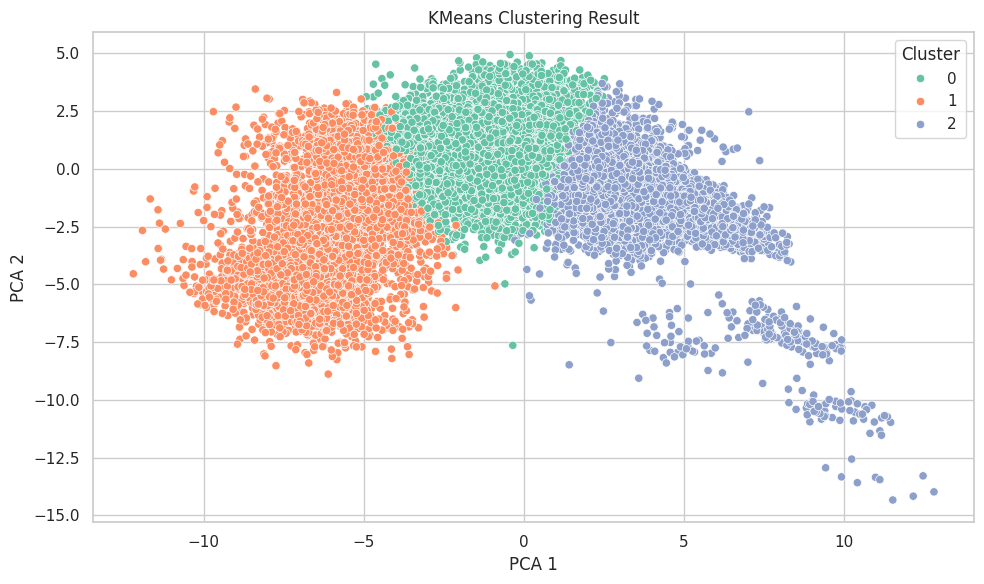

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged,
    x='pca1', y='pca2',
    hue='cluster',
    palette='Set2'
)
plt.title("KMeans Clustering Result")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title='Cluster')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import zscore

# 1. 수치형 피처만 선택 (cluster, 전투력 등 제외)
drop_cols = ['cluster', '전투력'] if '전투력' in merged.columns else ['cluster']
numeric_cols = merged.select_dtypes(include='number').drop(columns=drop_cols).columns

# 2. 클러스터별 평균 계산
cluster_means = merged.groupby('cluster')[numeric_cols].mean()

# 3. 클러스터 간 분산 계산 → 가장 편차 큰 피처 상위 50개 선택
top_50_features = cluster_means.var().sort_values(ascending=False).head(50).index

# 4. 해당 피처들의 클러스터 평균값 → z-score 변환
top_cluster_means = cluster_means[top_50_features]
zscore_df = top_cluster_means.apply(zscore, axis=0)

# 클러스터 순서 변경 (1, 0, 2)
zscore_df_reordered = zscore_df.loc[[1, 0, 2]]

# 컬럼 알파벳/한글 이름순 정렬
zscore_df_reordered = zscore_df_reordered[sorted(zscore_df_reordered.columns)]

# 결과 확인
zscore_df_reordered.round(2)

,ability_basic,ability_special,add_basic_score,add_special_score,additional_potential_option_grade,artifact_basic,artifact_special,base_basic_score,base_special_score,champion_badges,etc_basic_score,etc_special_score,exceptional_basic_score,exceptional_special_score,hexa_main_basic,hexa_main_special,hexa_sub_basic,hexa_sub_special,hyper_basic,hyper_special,level,pca1,pca2,potential_option_grade,star_basic_score,star_special_score,starforce,symbol_level,union_artifact_level,union_level,기타,루타비스,아케인,에테르넬,여명,칠흑
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.38,-1.38,-1.26,-1.41,-1.29,-0.57,-1.40,0.78,-1.31,-1.40,-0.46,-1.39,-0.71,-0.71,-1.35,-0.97,-1.40,-1.10,-1.39,-1.38,-1.14,-1.27,-1.25,-1.41,-1.27,-1.26,-1.33,-1.11,-1.32,-1.33,0.25,-0.93,-1.37,-1.07,-1.41,-0.83
0,-0.41,0.41,1.18,0.69,0.14,1.41,0.56,0.63,0.18,0.55,1.39,0.47,-0.71,-0.70,0.31,-0.40,0.53,-0.22,0.90,0.42,-0.16,0.10,1.19,0.56,0.09,0.08,0.26,-0.21,0.22,0.26,1.08,1.39,0.39,-0.26,0.68,-0.58
2,-0.97,0.97,0.08,0.72,1.15,-0.84,0.85,-1.41,1.12,0.85,-0.93,0.92,1.41,1.41,1.04,1.38,0.87,1.32,0.49,0.96,1.30,1.17,0.06,0.84,1.18,1.18,1.07,1.32,1.10,1.07,-1.33,-0.46,0.98,1.34,0.73,1.41


In [ ]:
sample = merged[merged['cluster'] == 1].sample(n=10, random_state=42)[['nickname', 'level', 'subclass', '기타',	'루타비스',	'아케인',	'에테르넬',	'여명',	'칠흑']]

sample

,nickname,level,subclass,기타,루타비스,아케인,에테르넬,여명,칠흑
12547,보끄엥,280,스트라이커,13.0,0.0,0.0,0.0,2.0,0.0
40393,중력2,286,플레임위자드,11.0,2.0,1.0,1.0,0.0,0.0
33598,멸망,290,섀도어,7.0,0.0,0.0,1.0,0.0,0.0
19147,균캡,284,캡틴,20.0,3.0,0.0,1.0,0.0,0.0
22678,메르디아,290,메르세데스,11.0,3.0,0.0,1.0,0.0,2.0
24392,놔요,287,패스파인더,17.0,3.0,2.0,1.0,1.0,0.0
29667,뽀식이네칼리,283,칼리,8.0,0.0,0.0,1.0,0.0,0.0
8776,팔라딘e,285,팔라딘,9.0,0.0,0.0,1.0,0.0,0.0
44762,백계루미,282,루미너스,21.0,2.0,1.0,0.0,0.0,0.0
2535,데련,285,데몬슬레이어,20.0,2.0,0.0,1.0,1.0,0.0


In [ ]:
sample = merged[merged['cluster'] == 0].sample(n=10, random_state=42)[['nickname', 'level', 'subclass', '기타',	'루타비스',	'아케인',	'에테르넬',	'여명',	'칠흑']]

sample

,nickname,level,subclass,기타,루타비스,아케인,에테르넬,여명,칠흑
36859,초구안타,288,"아크메이지(썬,콜)",12.0,3.0,4.0,1.0,4.0,0.0
17532,뽐뽀,285,은월,19.0,3.0,0.0,1.0,1.0,0.0
37921,문예창작,282,배틀메이지,16.0,3.0,0.0,1.0,2.0,1.0
28132,샛별빛나,289,듀얼블레이더,15.0,3.0,1.0,1.0,4.0,0.0
6705,무색폴암,285,아란,8.0,3.0,4.0,1.0,2.0,6.0
292,HB샤프아이즈,285,미하일,15.0,0.0,3.0,5.0,0.0,1.0
12417,OS원리와구조,281,스트라이커,12.0,3.0,5.0,0.0,4.0,0.0
43697,염전노예정령,285,라라,12.0,3.0,4.0,1.0,4.0,0.0
8254,발견,288,팔라딘,12.0,3.0,4.0,1.0,3.0,1.0
19646,보마둥둥이,290,보우마스터,14.0,3.0,4.0,1.0,2.0,0.0


In [ ]:
sample = merged[merged['cluster'] == 2].sample(n=10, random_state=42)[['nickname', 'level', 'subclass', '기타',	'루타비스',	'아케인',	'에테르넬',	'여명',	'칠흑']]

sample

,nickname,level,subclass,기타,루타비스,아케인,에테르넬,여명,칠흑
33481,샛돗어,290,섀도어,9.0,3.0,4.0,1.0,2.0,5.0
9970,뽀효지,290,제로,15.0,3.0,0.0,2.0,2.0,2.0
38829,또롱,290,비숍,5.0,0.0,3.0,5.0,2.0,9.0
7479,쩐뱌,286,다크나이트,6.0,0.0,0.0,8.0,2.0,8.0
26454,죠린,286,카데나,6.0,0.0,4.0,4.0,2.0,8.0
28143,악하람,289,듀얼블레이더,9.0,0.0,1.0,4.0,2.0,8.0
30351,은화,292,나이트로드,15.0,3.0,0.0,1.0,2.0,3.0
9531,무퍼,288,히어로,10.0,0.0,0.0,4.0,3.0,7.0
25950,꿈섬,288,윈드브레이커,5.0,0.0,4.0,4.0,2.0,9.0
24601,나뿐애,286,와일드헌터,10.0,3.0,4.0,1.0,2.0,4.0


In [ ]:
# cluster별 subclass 분포 개수
merged.groupby('cluster')['subclass'].value_counts().unstack(fill_value=0)

subclass,나이트로드,나이트워커,다크나이트,데몬슬레이어,데몬어벤져,듀얼블레이더,라라,루미너스,메르세데스,메카닉,미하일,바이퍼,배틀메이지,보우마스터,블래스터,비숍,섀도어,소울마스터,스트라이커,신궁,아델,아란,아크,"아크메이지(불,독)","아크메이지(썬,콜)",에반,엔젤릭버스터,와일드헌터,윈드브레이커,은월,일리움,제논,제로,카데나,카이저,카인,칼리,캐논마스터,캡틴,키네시스,팔라딘,패스파인더,팬텀,플레임위자드,호영,히어로
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,393,589,609,693,796,312,565,614,458,580,673,591,656,644,641,357,548,594,553,644,241,568,411,437,520,530,479,414,595,495,582,548,543,627,634,548,631,602,640,635,568,557,361,644,503,538
1,43,94,54,105,45,29,95,114,60,214,169,86,146,104,223,29,58,72,263,189,37,75,44,41,30,57,54,258,53,88,192,103,48,113,88,104,168,91,178,191,67,61,39,170,67,51
2,561,314,329,184,146,654,325,232,468,138,100,316,184,229,91,612,388,324,78,118,718,348,541,521,447,398,463,78,350,407,142,330,403,238,262,337,169,298,145,117,360,376,597,148,424,406


In [ ]:
# cluster별 subclass 비율
merged.groupby('cluster')['subclass'].value_counts(normalize=True).unstack(fill_value=0).round(3)

subclass,나이트로드,나이트워커,다크나이트,데몬슬레이어,데몬어벤져,듀얼블레이더,라라,루미너스,메르세데스,메카닉,미하일,바이퍼,배틀메이지,보우마스터,블래스터,비숍,섀도어,소울마스터,스트라이커,신궁,아델,아란,아크,"아크메이지(불,독)","아크메이지(썬,콜)",에반,엔젤릭버스터,와일드헌터,윈드브레이커,은월,일리움,제논,제로,카데나,카이저,카인,칼리,캐논마스터,캡틴,키네시스,팔라딘,패스파인더,팬텀,플레임위자드,호영,히어로
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.015,0.023,0.024,0.027,0.031,0.012,0.022,0.024,0.018,0.023,0.027,0.023,0.026,0.025,0.025,0.014,0.022,0.023,0.022,0.025,0.010,0.022,0.016,0.017,0.021,0.021,0.019,0.016,0.023,0.020,0.023,0.022,0.021,0.025,0.025,0.022,0.025,0.024,0.025,0.025,0.022,0.022,0.014,0.025,0.020,0.021
1,0.009,0.020,0.012,0.023,0.010,0.006,0.020,0.024,0.013,0.046,0.036,0.018,0.031,0.022,0.048,0.006,0.012,0.015,0.056,0.041,0.008,0.016,0.009,0.009,0.006,0.012,0.012,0.055,0.011,0.019,0.041,0.022,0.010,0.024,0.019,0.022,0.036,0.020,0.038,0.041,0.014,0.013,0.008,0.036,0.014,0.011
2,0.038,0.021,0.022,0.012,0.010,0.044,0.022,0.016,0.032,0.009,0.007,0.021,0.012,0.015,0.006,0.041,0.026,0.022,0.005,0.008,0.048,0.023,0.037,0.035,0.030,0.027,0.031,0.005,0.024,0.027,0.010,0.022,0.027,0.016,0.018,0.023,0.011,0.020,0.010,0.008,0.024,0.025,0.040,0.010,0.029,0.027


### GMM

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# 1. GMM 클러스터링 실행
gmm = GaussianMixture(n_components=3, covariance_type='diag', random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

# 2. 클러스터 결과 저장
merged['gmm_cluster'] = gmm_labels

# 3. 실루엣 스코어 계산
gmm_silhouette = silhouette_score(X_scaled, gmm_labels)

print("GMM 실루엣 스코어:", gmm_silhouette)

GMM 실루엣 스코어: 0.2304618565483953


In [ ]:
merged['gmm_cluster'].value_counts()

,count
gmm_cluster,
0,35162
1,9034
2,639


In [ ]:
merged.groupby('gmm_cluster').mean(numeric_only=True)

,level,union_level,union_artifact_level,champion_badges,ability_special,ability_basic,symbol_level,artifact_special,artifact_basic,hyper_special,hyper_basic,hexa_main_special,hexa_main_basic,hexa_sub_special,hexa_sub_basic,potential_option_grade,additional_potential_option_grade,starforce,base_basic_score,base_special_score,exceptional_basic_score,exceptional_special_score,add_basic_score,add_special_score,etc_basic_score,etc_special_score,star_basic_score,star_special_score,기타,루타비스,아케인,에테르넬,여명,칠흑,전투력,cluster,pca1,pca2
gmm_cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,287.616916,9303.457881,51.496445,1.000000,3.000000,0.000000,178.286986,113.794039,0.695381,60.804277,7.042461,17.069791,5.637393,41.558700,14.445140,75.379927,54.046983,308.010722,10446.845543,3363.370371,0.000000,0.000000,5402.513025,324.630851,11448.954240,1037.105654,7723.093908,7456.868466,13.290712,2.028383,1.883880,1.965389,2.228514,2.427763,1.611703e+08,0.778653,0.809572,0.259476
1,284.909675,8926.117667,46.433584,0.349126,2.725482,0.274518,168.209431,80.790015,0.696369,60.389971,6.537968,10.822116,3.349900,26.091875,9.566969,57.549258,35.881337,206.096524,12693.130728,2541.929931,0.000000,0.000000,4740.491366,290.272305,10934.155302,714.296546,4800.586894,4125.429046,13.942772,1.756033,1.658844,0.964135,1.564534,0.799646,7.352706e+07,0.623533,-3.644007,-0.682640
2,291.602504,9586.679186,55.577465,0.998435,2.857590,0.142410,193.528951,118.810642,0.674491,60.843505,6.730829,39.261346,1.491393,66.192488,2.497653,79.251956,76.298905,389.464789,7116.619718,4852.175274,979.780908,13.802817,4511.863850,308.317684,4701.244131,1108.295775,11651.569640,12408.347418,5.917058,0.037559,1.682316,6.173709,1.862285,8.262911,4.600611e+08,1.996870,6.969931,-4.627094


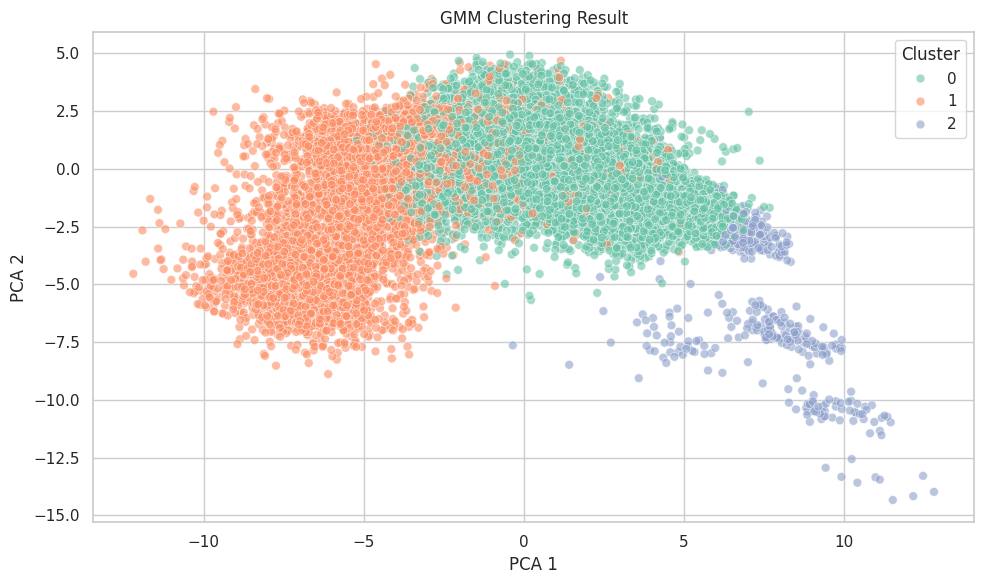

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=merged,
    x='pca1', y='pca2',
    hue='gmm_cluster',
    palette='Set2',
    alpha=0.6,
    s=40
)
plt.title("GMM Clustering Result")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

#### 확인용

In [ ]:
# 1. 한글 → 영어 이름 매핑
col_name_map = {
    'level': 'Level',
    'artifact_special': 'Artifact (Special)',
    'artifact_basic': 'Artifact (Basic)',
    'hyper_special': 'Hyper (Special)',
    'hyper_basic': 'Hyper (Basic)',
    'hexa_main_special': 'Hexa Main (Special)',
    'hexa_main_basic': 'Hexa Main (Basic)',
    'hexa_sub_special': 'Hexa Sub (Special)',
    'hexa_sub_basic': 'Hexa Sub (Basic)',
    '기타': 'Etc Equip',
    '루타비스': 'Root Abyss',
    '아케인': 'Arcane Shade',
    '에테르넬': 'Eternal',
    '여명': 'Dawn',
    '칠흑': 'Dark Boss Set'
}

# 2. 상관계수 계산
cols_to_check = list(col_name_map.keys()) + ['전투력']
corr_result = merged[cols_to_check].corr()['전투력'].drop('전투력')

# 3. 이름 변환하여 출력
corr_result.index = [col_name_map.get(col, col) for col in corr_result.index]
print(corr_result.sort_values(ascending=False).round(3))

Dark Boss Set          0.539
Hexa Main (Special)    0.474
Hexa Sub (Special)     0.444
Level                  0.394
Eternal                0.387
Artifact (Special)     0.334
Hexa Main (Basic)      0.066
Dawn                   0.033
Artifact (Basic)       0.032
Arcane Shade           0.025
Hyper (Basic)          0.025
Hexa Sub (Basic)       0.018
Hyper (Special)        0.011
Root Abyss            -0.097
Etc Equip             -0.322
Name: 전투력, dtype: float64


In [ ]:
# 1. 한글 → 영어 이름 매핑
col_name_map = {
    'level': 'Level',
    '전투력': 'Power',
    '기타': 'Etc Equip',
    '루타비스': 'Root Abyss',
    '아케인': 'Arcane Shade',
    '에테르넬': 'Eternal',
    '여명': 'Dawn',
    '칠흑': 'Dark Boss Set'
}

# 2. 상관계수 계산
cols_to_check = list(col_name_map.keys()) + ['hexa_main_special']
corr_result = merged[cols_to_check].corr()['hexa_main_special'].drop('hexa_main_special')

# 3. 이름 변환하여 출력
corr_result.index = [col_name_map.get(col, col) for col in corr_result.index]
print(corr_result.sort_values(ascending=False).round(3))

Level            0.501
Power            0.474
Dark Boss Set    0.441
Eternal          0.315
Arcane Shade    -0.007
Dawn            -0.091
Root Abyss      -0.125
Etc Equip       -0.298
Name: hexa_main_special, dtype: float64


## 클러스터링 + KNN

### KMeans - KNN

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# 1. 수치형 컬럼 선택
drop_cols = ['nickname', 'subclass']
numeric_cols = merged.drop(columns=drop_cols).select_dtypes(include='number').columns

# 2. feature_cols 설정 (cluster, pca 제외)
drop_cols += ['cluster', 'pca1', 'pca2']
feature_cols = [col for col in merged.columns if col in numeric_cols and col not in drop_cols]

# 3. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged[feature_cols])

# 4. KMeans 학습 + 클러스터 할당
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_scaled)
merged['cluster'] = kmeans.labels_

# 5. PCA 시각화용
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
merged['pca1'] = X_pca[:, 0]
merged['pca2'] = X_pca[:, 1]

# 6. 유저 정보
new_user_info = {
    'level': 250,
    'symbol_level': 65,
    'starforce': 151,
    '기타': 24,
    '루타비스': 0,
    '아케인': 0,
    '에테르넬': 0,
    '여명': 0,
    '칠흑': 0,
    '전투력': 5181594,
    'subclass': '비숍'
}

# 7. 유저 feature 구성
new_user_full = {col: new_user_info.get(col, 0) for col in feature_cols}
user_df = pd.DataFrame([new_user_full])
new_scaled = scaler.transform(user_df[feature_cols])
target_subclass = new_user_info['subclass']
user_cluster = kmeans.predict(new_scaled)[0]

# 8. 추천 대상 필터링
filtered_df = merged[
    (merged['subclass'] == target_subclass) &
    (merged['cluster'] == user_cluster)
].copy()
filtered_scaled = X_scaled[
    (merged['subclass'] == target_subclass) &
    (merged['cluster'] == user_cluster)
]

# 9. KNN 추천
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(filtered_scaled)
distances, indices = knn.kneighbors(new_scaled)

# 10. 추천 결과 출력
output_columns = ['nickname', 'subclass', 'cluster'] + feature_cols
recommended_users = filtered_df.iloc[indices[0]][output_columns].copy()

pd.set_option('display.float_format', '{:.0f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

recommended_users

,nickname,subclass,cluster,level,union_level,union_artifact_level,champion_badges,ability_special,ability_basic,symbol_level,artifact_special,artifact_basic,hyper_special,hyper_basic,hexa_main_special,hexa_main_basic,hexa_sub_special,hexa_sub_basic,potential_option_grade,additional_potential_option_grade,starforce,base_basic_score,base_special_score,exceptional_basic_score,exceptional_special_score,add_basic_score,add_special_score,etc_basic_score,etc_special_score,star_basic_score,star_special_score,기타,루타비스,아케인,에테르넬,여명,칠흑,전투력
38614,밍잇,비숍,1,291,9813,47,0,2,1,178,0,0,59,9,0,8,32,0,31,22,65,13090,1062,0,0,293,272,12441,285,1696,830,9,0,0,1,0,1,32894952
38981,새로캐릭이름,비숍,1,290,9445,50,0,3,0,183,0,0,51,6,10,0,15,15,28,18,35,12050,991,0,0,200,351,6302,208,951,507,7,0,0,1,0,2,25278269
38691,Pool,비숍,1,291,9229,52,0,3,0,175,0,0,59,8,4,4,24,8,19,15,42,2946,969,0,0,298,268,7593,225,1205,897,9,0,0,1,0,0,24102333
38453,냥쭐,비숍,1,291,9100,48,1,3,0,178,105,0,59,10,15,0,14,11,12,12,30,480,741,0,0,0,217,32,122,876,474,3,0,0,1,0,0,100202363
38948,비숍할배,비숍,1,290,9111,51,0,3,0,185,0,0,59,8,26,0,54,0,28,18,52,4918,1135,0,0,336,309,12413,267,1400,1080,7,0,0,1,0,2,23882176


In [ ]:
print("📏 거리 정보:")
for i, dist in enumerate(distances[0]):
    print(f"{i+1}번째 유저와의 거리: {dist:.6f}")

📏 거리 정보:
1번째 유저와의 거리: 31.886684
2번째 유저와의 거리: 31.967403
3번째 유저와의 거리: 32.179958
4번째 유저와의 거리: 32.336528
5번째 유저와의 거리: 32.445612


### GMM - KNN

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# 1. 수치형 컬럼 선택
drop_cols = ['nickname', 'subclass']
numeric_cols = merged.drop(columns=drop_cols).select_dtypes(include='number').columns
feature_cols = list(numeric_cols)

# 2. 스케일링 (표준화)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged[feature_cols])

# 3. PCA로 시각화용 차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
merged['pca1'] = X_pca[:, 0]
merged['pca2'] = X_pca[:, 1]

# 4. 유저 정보
new_user_info = {
    'level': 250,
    'symbol_level': 65,
    'starforce': 151,
    '기타': 24,
    '루타비스': 0,
    '아케인': 0,
    '에테르넬': 0,
    '여명': 0,
    '칠흑': 0,
    '전투력': 5181594,
    'subclass': '비숍'
}

new_user_full = {col: new_user_info.get(col, 0) for col in feature_cols}
target_subclass = new_user_info['subclass']
user_df = pd.DataFrame([new_user_full])

# 5. GMM 클러스터링 수행
gmm = GaussianMixture(n_components=3, covariance_type='diag', random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
merged['gmm_cluster'] = gmm_labels

# 6. 유저 GMM 클러스터 예측
new_scaled = scaler.transform(user_df[feature_cols])
user_gmm_cluster = gmm.predict(new_scaled)[0]

# 7. 필터링 (subclass + gmm_cluster)
filtered_df = merged[
    (merged['subclass'] == target_subclass) &
    (merged['gmm_cluster'] == user_gmm_cluster)
].copy()
filtered_scaled = X_scaled[
    (merged['subclass'] == target_subclass) &
    (merged['gmm_cluster'] == user_gmm_cluster)
]

# 8. KNN 추천
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(filtered_scaled)
distances, indices = knn.kneighbors(new_scaled)

# 9. 결과 출력
output_columns = ['nickname', 'subclass', 'gmm_cluster'] + feature_cols
recommended_users = filtered_df.iloc[indices[0]][output_columns]

pd.set_option('display.float_format', '{:.0f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

recommended_users

,nickname,subclass,gmm_cluster,level,union_level,union_artifact_level,champion_badges,ability_special,ability_basic,symbol_level,artifact_special,artifact_basic,hyper_special,hyper_basic,hexa_main_special,hexa_main_basic,hexa_sub_special,hexa_sub_basic,potential_option_grade,additional_potential_option_grade,starforce,base_basic_score,base_special_score,exceptional_basic_score,exceptional_special_score,add_basic_score,add_special_score,etc_basic_score,etc_special_score,star_basic_score,star_special_score,기타,루타비스,아케인,에테르넬,여명,칠흑,전투력,cluster,pca1,pca2
38940,을빛,비숍,0,290,9029,51,1,3,0,183,117,0,50,0,13,6,24,17,70,43,259,6004,3044,0,0,4992,329,4702,653,5920,4726,13,3,4,1,0,2,65942909,0,-1,-1
38947,료휜,비숍,0,290,9030,49,1,2,1,187,105,0,60,8,16,10,64,30,79,44,261,10093,2764,0,0,4614,269,11742,907,6010,6351,21,2,0,1,0,0,73728323,0,-1,0
38902,핑뷰,비숍,0,290,8911,50,1,3,0,181,114,0,55,5,0,7,13,0,64,38,218,22902,2858,0,0,8140,327,5767,711,4667,4642,14,3,0,1,0,3,60407194,0,-3,-1
38501,베리,비숍,0,291,9659,51,1,2,1,184,117,0,55,2,23,0,57,0,62,28,171,7823,3148,0,0,1385,365,14578,442,4315,2937,13,3,4,1,1,1,86759110,0,-2,-2
39017,멍수아,비숍,0,290,9083,41,0,3,0,186,74,4,60,6,27,0,59,14,74,50,212,2983,3078,0,0,3831,486,9182,678,4945,5035,18,2,0,3,0,1,54755972,0,-2,-1


In [ ]:
# 실루엣 스코어 계산
gmm_silhouette = silhouette_score(X_scaled, gmm_labels)

print("GMM 실루엣 스코어:", gmm_silhouette)

GMM 실루엣 스코어: 0.1826500075430714


In [ ]:
print("📏 거리 정보 (GMM 기반):")
for i, dist in enumerate(distances[0]):
    print(f"{i+1}번째 유저와의 거리: {dist:.6f}")

📏 거리 정보 (GMM 기반):
1번째 유저와의 거리: 32.730909
2번째 유저와의 거리: 32.785343
3번째 유저와의 거리: 32.792688
4번째 유저와의 거리: 33.038175
5번째 유저와의 거리: 33.090188


### GMM - KNN 튜닝

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

# 4. 유저 정보
new_user_info = {
    'level': 250,
    'symbol_level': 65,
    'starforce': 151,
    '기타': 24,
    '루타비스': 0,
    '아케인': 0,
    '에테르넬': 0,
    '여명': 0,
    '칠흑': 0,
    '전투력': 5181594,
    'subclass': '비숍'
}

new_user_full = {col: new_user_info.get(col, 0) for col in feature_cols}
target_subclass = new_user_info['subclass']
user_df = pd.DataFrame([new_user_full])

# 5. GMM 클러스터링 수행 -> 튜닝
gmm = GaussianMixture(n_components=2, covariance_type='tied', random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)
merged['gmm_cluster'] = gmm_labels

# 6. 유저 GMM 클러스터 예측
new_scaled = scaler.transform(user_df[feature_cols])
user_gmm_cluster = gmm.predict(new_scaled)[0]

# 7. 필터링 (subclass + gmm_cluster)
filtered_df = merged[
    (merged['subclass'] == target_subclass) &
    (merged['gmm_cluster'] == user_gmm_cluster)
].copy()
filtered_scaled = X_scaled[
    (merged['subclass'] == target_subclass) &
    (merged['gmm_cluster'] == user_gmm_cluster)
]

# 8. KNN 추천
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(filtered_scaled)
distances, indices = knn.kneighbors(new_scaled)

# 9. 결과 출력
output_columns = ['nickname', 'subclass', 'gmm_cluster'] + feature_cols
recommended_users = filtered_df.iloc[indices[0]][output_columns]

pd.set_option('display.float_format', '{:.0f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

recommended_users

,nickname,subclass,gmm_cluster,level,union_level,union_artifact_level,champion_badges,ability_special,ability_basic,symbol_level,artifact_special,artifact_basic,hyper_special,hyper_basic,hexa_main_special,hexa_main_basic,hexa_sub_special,hexa_sub_basic,potential_option_grade,additional_potential_option_grade,starforce,base_basic_score,base_special_score,exceptional_basic_score,exceptional_special_score,add_basic_score,add_special_score,etc_basic_score,etc_special_score,star_basic_score,star_special_score,기타,루타비스,아케인,에테르넬,여명,칠흑,전투력,cluster,pca1,pca2
38614,밍잇,비숍,1,291,9813,47,0,2,1,178,0,0,59,9,0,8,32,0,31,22,65,13090,1062,0,0,293,272,12441,285,1696,830,9,0,0,1,0,1,32894952,1,-7,-5
38981,새로캐릭이름,비숍,1,290,9445,50,0,3,0,183,0,0,51,6,10,0,15,15,28,18,35,12050,991,0,0,200,351,6302,208,951,507,7,0,0,1,0,2,25278269,1,-7,-7
38691,Pool,비숍,1,291,9229,52,0,3,0,175,0,0,59,8,4,4,24,8,19,15,42,2946,969,0,0,298,268,7593,225,1205,897,9,0,0,1,0,0,24102333,1,-7,-7
38453,냥쭐,비숍,1,291,9100,48,1,3,0,178,105,0,59,10,15,0,14,11,12,12,30,480,741,0,0,0,217,32,122,876,474,3,0,0,1,0,0,100202363,1,-6,-7
38948,비숍할배,비숍,1,290,9111,51,0,3,0,185,0,0,59,8,26,0,54,0,28,18,52,4918,1135,0,0,336,309,12413,267,1400,1080,7,0,0,1,0,2,23882176,1,-6,-7


In [ ]:
# 실루엣 스코어 계산
gmm_silhouette = silhouette_score(X_scaled, gmm_labels)

print("GMM 실루엣 스코어:", gmm_silhouette)

GMM 실루엣 스코어: 0.1776391007289814


In [ ]:
print("📏 거리 정보 (GMM 기반):")
for i, dist in enumerate(distances[0]):
    print(f"{i+1}번째 유저와의 거리: {dist:.6f}")

📏 거리 정보 (GMM 기반):
1번째 유저와의 거리: 32.078100
2번째 유저와의 거리: 32.207295
3번째 유저와의 거리: 32.425704
4번째 유저와의 거리: 32.590394
5번째 유저와의 거리: 32.688177


### 전투력 구간화 - KNN

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

merged_ddff = merged.copy()

# 1. 전투력 NaN 제거 후 KMeans 클러스터링
power_values = merged_ddff[['전투력']].dropna().values
power_kmeans = KMeans(n_clusters=3, random_state=42)
power_labels = power_kmeans.fit_predict(power_values)
merged_ddff.loc[merged_ddff['전투력'].notna(), 'power_cluster'] = power_labels

# 2. 전체 NaN 제거 후 추천용 데이터 구성
merged_ddff = merged_ddff.dropna().reset_index(drop=True)

# 3. 스케일링 feature 고정 (클러스터링 정보 제외)
drop_cols = ['nickname', 'subclass', 'gmm_cluster', 'power_cluster']
feature_cols = [col for col in merged_ddff.columns if col not in drop_cols]

# 4. 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(merged_ddff[feature_cols])

# 5. 유저 정보 입력
new_user_info = {
    'level': 250,
    'symbol_level': 65,
    'starforce': 151,
    '기타': 24,
    '루타비스': 0,
    '아케인': 0,
    '에테르넬': 0,
    '여명': 0,
    '칠흑': 0,
    '전투력': 5181594,
    'subclass': '비숍'
}

# 6. 입력 feature 채우기
new_user_full = {col: new_user_info.get(col, 0) for col in feature_cols}
target_subclass = new_user_info['subclass']
target_power_cluster = power_kmeans.predict([[new_user_info['전투력']]])[0]

# 7. user_df 및 스케일링
user_df = pd.DataFrame([new_user_full])
new_scaled = scaler.transform(user_df[feature_cols])

# 8. 필터링 (subclass + power_cluster)
filtered_df = merged_ddff[
    (merged_ddff['subclass'] == target_subclass) &
    (merged_ddff['power_cluster'] == target_power_cluster)
].copy()
filtered_scaled = X_scaled[
    (merged_ddff['subclass'] == target_subclass) &
    (merged_ddff['power_cluster'] == target_power_cluster)
]

# 9. KNN 추천
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(filtered_scaled)
distances, indices = knn.kneighbors(new_scaled)

# 10. 결과 출력
output_columns = ['nickname', 'subclass'] + feature_cols
recommended_users = filtered_df.iloc[indices[0]][output_columns].copy()

recommended_users

,nickname,subclass,level,union_level,union_artifact_level,champion_badges,ability_special,ability_basic,symbol_level,artifact_special,artifact_basic,hyper_special,hyper_basic,hexa_main_special,hexa_main_basic,hexa_sub_special,hexa_sub_basic,potential_option_grade,additional_potential_option_grade,starforce,base_basic_score,base_special_score,exceptional_basic_score,exceptional_special_score,add_basic_score,add_special_score,etc_basic_score,etc_special_score,star_basic_score,star_special_score,기타,루타비스,아케인,에테르넬,여명,칠흑,전투력
38614,밍잇,비숍,291,9813,47,0,2,1,178,0,0,59,9,0,8,32,0,31,22,65,13090,1062,0,0,293,272,12441,285,1696,830,9,0,0,1,0,1,32894952
38981,새로캐릭이름,비숍,290,9445,50,0,3,0,183,0,0,51,6,10,0,15,15,28,18,35,12050,991,0,0,200,351,6302,208,951,507,7,0,0,1,0,2,25278269
38691,Pool,비숍,291,9229,52,0,3,0,175,0,0,59,8,4,4,24,8,19,15,42,2946,969,0,0,298,268,7593,225,1205,897,9,0,0,1,0,0,24102333
38453,냥쭐,비숍,291,9100,48,1,3,0,178,105,0,59,10,15,0,14,11,12,12,30,480,741,0,0,0,217,32,122,876,474,3,0,0,1,0,0,100202363
38948,비숍할배,비숍,290,9111,51,0,3,0,185,0,0,59,8,26,0,54,0,28,18,52,4918,1135,0,0,336,309,12413,267,1400,1080,7,0,0,1,0,2,23882176


In [ ]:
print("📏 거리 정보 (유사도 기준):")
for i, dist in enumerate(distances[0]):
    print(f"{i+1}번째 유저와의 거리: {dist:.6f}")

📏 거리 정보 (유사도 기준):
1번째 유저와의 거리: 31.886684
2번째 유저와의 거리: 31.967403
3번째 유저와의 거리: 32.179958
4번째 유저와의 거리: 32.336528
5번째 유저와의 거리: 32.445612


#### 확인용

In [ ]:
print("일리움 유저 수:", merged[merged['subclass'] == '일리움'].shape[0])

일리움 유저 수: 916


In [ ]:
pd.crosstab(merged['gmm_cluster'], merged_ddff['power_cluster'])

power_cluster,0.0,1.0,2.0
gmm_cluster,,,
0,17,269,353
1,8278,692,64
2,22380,10709,2073


In [ ]:
print(merged['gmm_cluster'].value_counts())
print(merged_ddff['power_cluster'].value_counts())

gmm_cluster
2    35162
1     9034
0      639
Name: count, dtype: int64
power_cluster
0.0    30675
1.0    11670
2.0     2490
Name: count, dtype: int64


## 분류모델

In [ ]:
# ✅ 전투력 구간 라벨링 + 전체 feature 클러스터링 + 장비 정보 기반 분류모델 비교

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. 분류모델용 장비 feature (potential_option_grade ~ 칠흑)
feature_cols = merged.loc[:, 'potential_option_grade':'칠흑'].columns.tolist()
X_raw = merged[feature_cols].copy()

# 2. 전투력 구간 라벨링
combat_bins = pd.qcut(merged['전투력'], q=3, labels=False)
y = combat_bins

# 3. 클러스터링용 feature (전투력 제외한 모든 수치형)
cluster_cols = merged.select_dtypes(include='number').drop(columns='전투력').columns.tolist()
X_cluster = merged[cluster_cols].copy()
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# 4. KMeans 군집화
kmeans = KMeans(n_clusters=3, random_state=42)
merged['cluster'] = kmeans.fit_predict(X_cluster_scaled)

# 5. 분류모델용 데이터 구성
X_clustered = X_raw.copy()
X_clustered['cluster'] = merged['cluster']

# 6. train-test 분할 (cluster 포함/제외 각각)
X_train1, X_test1, y_train, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=42)
X_train2, X_test2, _, _ = train_test_split(X_clustered, y, test_size=0.3, random_state=42)

# 7. 모델 훈련
model1 = RandomForestClassifier(random_state=42)
model2 = RandomForestClassifier(random_state=42)
model1.fit(X_train1, y_train)
model2.fit(X_train2, y_train)

# 8. 예측 및 결과 비교
print("📊 [Without Cluster Feature]")
y_pred1 = model1.predict(X_test1)
print(classification_report(y_test, y_pred1))

print("\n📊 [With Cluster Feature]")
y_pred2 = model2.predict(X_test2)
print(classification_report(y_test, y_pred2))

📊 [Without Cluster Feature]
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      4482
           1       0.50      0.54      0.52      4467
           2       0.67      0.65      0.66      4502

    accuracy                           0.65     13451
   macro avg       0.66      0.65      0.65     13451
weighted avg       0.66      0.65      0.65     13451


📊 [With Cluster Feature]
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      4482
           1       0.51      0.54      0.53      4467
           2       0.67      0.65      0.66      4502

    accuracy                           0.65     13451
   macro avg       0.66      0.65      0.65     13451
weighted avg       0.66      0.65      0.65     13451



In [ ]:
# ✅ 전투력 구간 라벨링 + 전체 feature 클러스터링 + 장비 정보 기반 분류모델 비교 (튜닝 적용)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# 1. 분류모델용 장비 feature (potential_option_grade ~ 칠흑)
feature_cols = merged.loc[:, 'potential_option_grade':'칠흑'].columns.tolist()
X_raw = merged[feature_cols].copy()

# 2. 전투력 구간 라벨링
combat_bins = pd.qcut(merged['전투력'], q=3, labels=False)
y = combat_bins

# 3. 클러스터링용 feature (전투력 제외한 모든 수치형)
cluster_cols = merged.select_dtypes(include='number').drop(columns='전투력').columns.tolist()
X_cluster = merged[cluster_cols].copy()
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# 4. KMeans 군집화
kmeans = KMeans(n_clusters=3, random_state=42)
merged['cluster'] = kmeans.fit_predict(X_cluster_scaled)

# 5. 분류모델용 데이터 구성
X_clustered = X_raw.copy()
X_clustered['cluster'] = merged['cluster']

# 6. train-test 분할 (cluster 포함/제외 각각)
X_train1, X_test1, y_train, y_test = train_test_split(X_raw, y, test_size=0.3, random_state=42)
X_train2, X_test2, _, _ = train_test_split(X_clustered, y, test_size=0.3, random_state=42)

# 7. 모델 훈련 (튜닝 적용)
model1 = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model2 = RandomForestClassifier(
    n_estimators=300,
    max_depth=15,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

model1.fit(X_train1, y_train)
model2.fit(X_train2, y_train)

# 8. 예측 및 결과 비교
print("📊 [Without Cluster Feature]")
y_pred1 = model1.predict(X_test1)
print(classification_report(y_test, y_pred1))

print("\n📊 [With Cluster Feature]")
y_pred2 = model2.predict(X_test2)
print(classification_report(y_test, y_pred2))

📊 [Without Cluster Feature]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      4482
           1       0.50      0.56      0.53      4467
           2       0.68      0.65      0.66      4502

    accuracy                           0.66     13451
   macro avg       0.66      0.66      0.66     13451
weighted avg       0.66      0.66      0.66     13451


📊 [With Cluster Feature]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      4482
           1       0.50      0.57      0.53      4467
           2       0.68      0.64      0.66      4502

    accuracy                           0.66     13451
   macro avg       0.67      0.66      0.66     13451
weighted avg       0.67      0.66      0.66     13451



In [ ]:
# ✅ 전투력 구간 라벨링 + 전체 feature 클러스터링 + 장비 정보 기반 분류모델 비교 (4개 모델 비교)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 1. 분류모델용 장비 feature (potential_option_grade ~ 칠흑)
feature_cols = merged.loc[:, 'potential_option_grade':'칠흑'].columns.tolist()
X_raw = merged[feature_cols].copy()

# 2. 전투력 구간 라벨링 (사분위수 기준 3분할)
combat_bins = pd.qcut(merged['전투력'], q=3, labels=False)
y = combat_bins

# 3. 클러스터링용 feature (전투력 제외한 모든 수치형)
cluster_cols = merged.select_dtypes(include='number').drop(columns='전투력').columns.tolist()
X_cluster = merged[cluster_cols].copy()
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# 4. KMeans 군집화
kmeans = KMeans(n_clusters=3, random_state=42)
merged['cluster'] = kmeans.fit_predict(X_cluster_scaled)

# 5. 분류모델용 데이터 구성
X_clustered = X_raw.copy()
X_clustered['cluster'] = merged['cluster']

# 6. train-test 분할 (cluster 포함)
X_train, X_test, y_train, y_test = train_test_split(X_clustered, y, test_size=0.3, random_state=42)

# 7. 모델 정의
rf_model = RandomForestClassifier(random_state=42)
lgbm_model = LGBMClassifier(verbose=-1, random_state=42)
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)
cat_model = CatBoostClassifier(verbose=0, random_state=42)

# 8. 모델 학습
rf_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
cat_model.fit(X_train, y_train)

# 9. 예측 및 결과 비교
print("📊 [Random Forest]")
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

print("\n📊 [LightGBM]")
y_pred_lgbm = lgbm_model.predict(X_test)
print(classification_report(y_test, y_pred_lgbm))

print("\n📊 [XGBoost]")
y_pred_xgb = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred_xgb))

print("\n📊 [CatBoost]")
y_pred_cat = cat_model.predict(X_test)
print(classification_report(y_test, y_pred_cat))

📊 [Random Forest]
              precision    recall  f1-score   support

           0       0.80      0.77      0.78      4482
           1       0.51      0.54      0.53      4467
           2       0.67      0.65      0.66      4502

    accuracy                           0.65     13451
   macro avg       0.66      0.65      0.65     13451
weighted avg       0.66      0.65      0.65     13451


📊 [LightGBM]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      4482
           1       0.50      0.57      0.53      4467
           2       0.68      0.64      0.66      4502

    accuracy                           0.66     13451
   macro avg       0.67      0.66      0.66     13451
weighted avg       0.67      0.66      0.66     13451


📊 [XGBoost]
              precision    recall  f1-score   support

           0       0.81      0.76      0.79      4482
           1       0.50      0.54      0.52      4467
           2       0.66      0

In [ ]:
# ✅ 전투력 구간 라벨링 + 전체 feature 클러스터링 + 장비 정보 기반 LightGBM 분류모델 (GridSearch 튜닝)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier

# 1. 분류모델용 장비 feature (potential_option_grade ~ 칠흑)
feature_cols = merged.loc[:, 'potential_option_grade':'칠흑'].columns.tolist()
X_raw = merged[feature_cols].copy()

# 2. 전투력 구간 라벨링 (사분위수 기준 3분할)
combat_bins = pd.qcut(merged['전투력'], q=3, labels=False)
y = combat_bins

# 3. 클러스터링용 feature (전투력 제외한 모든 수치형)
cluster_cols = merged.select_dtypes(include='number').drop(columns='전투력').columns.tolist()
X_cluster = merged[cluster_cols].copy()
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# 4. KMeans 군집화
kmeans = KMeans(n_clusters=3, random_state=42)
merged['cluster'] = kmeans.fit_predict(X_cluster_scaled)

# 5. 분류모델용 데이터 구성
X_clustered = X_raw.copy()
X_clustered['cluster'] = merged['cluster']

# 6. train-test 분할 (cluster 포함)
X_train, X_test, y_train, y_test = train_test_split(X_clustered, y, test_size=0.3, random_state=42)

# 7. LightGBM GridSearchCV 정의
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [10, 15, 20],
    'num_leaves': [31, 64, 128],
    'class_weight': ['balanced']
}

lgbm_grid = GridSearchCV(
    LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1),
    param_grid,
    cv=3,
    scoring='f1_macro',
    verbose=1
)

# 8. 모델 학습
lgbm_grid.fit(X_train, y_train)

# 9. 예측 및 결과 출력
print("\n📊 [LightGBM - GridSearch Best Model]")
y_pred_lgbm = lgbm_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_lgbm))

print("Best Parameters:")
print(lgbm_grid.best_params_)

Fitting 3 folds for each of 81 candidates, totalling 243 fits

📊 [LightGBM - GridSearch Best Model]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      4482
           1       0.50      0.57      0.53      4467
           2       0.68      0.64      0.66      4502

    accuracy                           0.66     13451
   macro avg       0.67      0.66      0.66     13451
weighted avg       0.67      0.66      0.66     13451

Best Parameters:
{'class_weight': 'balanced', 'learning_rate': 0.01, 'max_depth': 20, 'n_estimators': 500, 'num_leaves': 31}


## **회귀모델**

In [ ]:
!pip install catboost

In [ ]:
numeric_cols = merged.select_dtypes(include='number').columns
correlation_with_power = merged[numeric_cols].corr()['전투력'].drop('전투력').abs().sort_values(ascending=False)
top_features = correlation_with_power.head(20)
print(top_features)

star_special_score                   0.657287
additional_potential_option_grade    0.634455
star_basic_score                     0.602970
칠흑                                   0.538951
starforce                            0.526415
hexa_main_special                    0.473609
union_artifact_level                 0.450055
hexa_sub_special                     0.443555
potential_option_grade               0.436452
base_special_score                   0.435660
symbol_level                         0.434842
etc_special_score                    0.396676
level                                0.394079
에테르넬                                 0.387429
artifact_special                     0.334446
기타                                   0.321882
champion_badges                      0.312047
base_basic_score                     0.269292
union_level                          0.257808
exceptional_special_score            0.227043
Name: 전투력, dtype: float64


In [ ]:
# ✅ 전투력 예측 회귀모델 (상관계수 기반 상위 feature 20개 사용)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor

# 1. 상관계수 기준 상위 20개 feature 사용
top_features = [
    'star_special_score', 'additional_potential_option_grade', 'star_basic_score', '칠흑',
    'starforce', 'hexa_main_special', 'union_artifact_level', 'hexa_sub_special',
    'potential_option_grade', 'base_special_score', 'symbol_level', 'etc_special_score',
    'level', '에테르넬', 'artifact_special', '기타',
    'champion_badges', 'base_basic_score', 'union_level', 'exceptional_special_score'
]

# 2. X, y 정의
X = merged[top_features].copy()
y = merged['전투력']

# 3. train-test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. LightGBM 회귀모델 정의 및 학습
model = LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

# 5. 예측 및 평가
y_pred = model.predict(X_test)

print("📊 [LightGBM Regressor 성능 평가 - 상위 feature 기반]")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

📊 [LightGBM Regressor 성능 평가 - 상위 feature 기반]
MAE: 46921938.62038661
RMSE: 70413520.19372396
R²: 0.5592382322144192


In [ ]:
# ✅ 전투력 예측 회귀모델 (전체 feature 사용)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lightgbm import LGBMRegressor

# 1. 수치형 전체 feature 사용 (전투력 제외)
numeric_cols = merged.select_dtypes(include='number').columns.tolist()
feature_cols = [col for col in numeric_cols if col != '전투력']

# 2. X, y 정의
X = merged[feature_cols].copy()
y = merged['전투력']

# 3. train-test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. LightGBM 회귀모델 정의 및 학습
model = LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

# 5. 예측 및 평가
y_pred = model.predict(X_test)

print("📊 [LightGBM Regressor 성능 평가 - 전체 feature 기반]")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

📊 [LightGBM Regressor 성능 평가 - 전체 feature 기반]
MAE: 46706096.67151324
RMSE: 70161073.50401208
R²: 0.562393006703068


In [ ]:
# ✅ 전투력 예측 회귀모델 (XGBoost & CatBoost 비교)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# 1. 수치형 전체 feature 사용 (전투력 제외)
numeric_cols = merged.select_dtypes(include='number').columns.tolist()
feature_cols = [col for col in numeric_cols if col != '전투력']

# 2. X, y 정의
X = merged[feature_cols].copy()
y = merged['전투력']

# 3. train-test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. XGBoost 회귀모델
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("📊 [XGBoost 회귀모델 성능 평가]")
print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R²:", r2_score(y_test, y_pred_xgb))

# 5. CatBoost 회귀모델
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train, y_train)
y_pred_cat = cat_model.predict(X_test)

print("\n📊 [CatBoost 회귀모델 성능 평가]")
print("MAE:", mean_absolute_error(y_test, y_pred_cat))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_cat)))
print("R²:", r2_score(y_test, y_pred_cat))

📊 [XGBoost 회귀모델 성능 평가]
MAE: 47620366.183892
RMSE: 72917196.51111054
R²: 0.5273368678958457

📊 [CatBoost 회귀모델 성능 평가]
MAE: 46753477.977053955
RMSE: 70076526.5730197
R²: 0.5634470394929464


In [ ]:
# ✅ 전투력 예측 회귀모델 (Log 변환 적용 - XGBoost & CatBoost 비교)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# 1. 수치형 전체 feature 사용 (전투력 제외)
numeric_cols = merged.select_dtypes(include='number').columns.tolist()
feature_cols = [col for col in numeric_cols if col != '전투력']

# 2. X, y 정의 (log 변환 적용)
X = merged[feature_cols].copy()
y_log = np.log1p(merged['전투력'])

# 3. train-test 분할
X_train, X_test, y_train_log, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)

# 4. XGBoost 회귀모델 (로그 예측 후 역변환)
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train_log)
y_pred_log_xgb = xgb_model.predict(X_test)
y_pred_xgb = np.expm1(y_pred_log_xgb)  # 역변환

y_true = np.expm1(y_test)  # 테스트셋도 역변환

print("📊 [XGBoost 회귀모델 성능 평가 - log 변환]")
print("MAE:", mean_absolute_error(y_true, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred_xgb)))
print("R²:", r2_score(y_true, y_pred_xgb))

# 5. CatBoost 회귀모델
cat_model = CatBoostRegressor(verbose=0, random_state=42)
cat_model.fit(X_train, y_train_log)
y_pred_log_cat = cat_model.predict(X_test)
y_pred_cat = np.expm1(y_pred_log_cat)

print("\n📊 [CatBoost 회귀모델 성능 평가 - log 변환]")
print("MAE:", mean_absolute_error(y_true, y_pred_cat))
print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred_cat)))
print("R²:", r2_score(y_true, y_pred_cat))

📊 [XGBoost 회귀모델 성능 평가 - log 변환]
MAE: 45187499.09724433
RMSE: 72398684.68267225
R²: 0.5340351517987014

📊 [CatBoost 회귀모델 성능 평가 - log 변환]
MAE: 44730120.36644443
RMSE: 71501640.1848268
R²: 0.5455105447014704


In [ ]:
# ✅ 전투력 예측 회귀모델 (Log 변환 적용 - LightGBM, RandomForest 비교)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# 1. 수치형 전체 feature 사용 (전투력 제외)
numeric_cols = merged.select_dtypes(include='number').columns.tolist()
feature_cols = [col for col in numeric_cols if col != '전투력']

# 2. X, y 정의 (log 변환 적용)
X = merged[feature_cols].copy()
y_log = np.log1p(merged['전투력'])

# 3. train-test 분할
X_train, X_test, y_train_log, y_test = train_test_split(X, y_log, test_size=0.3, random_state=42)

# 4. 역변환 대상 준비
y_true = np.expm1(y_test)

# 5. LightGBM 회귀모델
lgbm_model = LGBMRegressor(random_state=42)
lgbm_model.fit(X_train, y_train_log)
y_pred_lgbm = np.expm1(lgbm_model.predict(X_test))

print("📊 [LightGBM 회귀모델 성능 평가 - log 변환]")
print("MAE:", mean_absolute_error(y_true, y_pred_lgbm))
print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred_lgbm)))
print("R²:", r2_score(y_true, y_pred_lgbm))

# 6. RandomForest 회귀모델
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train_log)
y_pred_rf = np.expm1(rf_model.predict(X_test))

print("\n📊 [RandomForest 회귀모델 성능 평가 - log 변환]")
print("MAE:", mean_absolute_error(y_true, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred_rf)))
print("R²:", r2_score(y_true, y_pred_rf))

📊 [LightGBM 회귀모델 성능 평가 - log 변환]
MAE: 45073565.426752865
RMSE: 72098027.55804722
R²: 0.5378972318231515

📊 [RandomForest 회귀모델 성능 평가 - log 변환]
MAE: 45626796.189992145
RMSE: 72426429.09732586
R²: 0.5336779519650411


In [ ]:
# ✅ 전투력 예측 회귀모델 (CatBoost + subclass 원핫 인코딩)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor

# 1. 수치형 + subclass 포함 (전투력 제외)
numeric_cols = merged.select_dtypes(include='number').columns.tolist()
feature_cols = [col for col in numeric_cols if col != '전투력']

# subclass 원핫 인코딩 추가
categorical_cols = ['subclass']
encoded = pd.get_dummies(merged[categorical_cols], drop_first=True)
X = pd.concat([merged[feature_cols], encoded], axis=1)

# 2. 전투력 사용 (log 변환 없이)
y = merged['전투력']

# 3. train-test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. CatBoost 회귀모델 학습 (튜닝 없이)
model = CatBoostRegressor(verbose=0, random_state=42)
model.fit(X_train, y_train)

# 5. 예측 및 평가
y_pred = model.predict(X_test)

print("📊 [CatBoost 회귀모델 성능 평가 - subclass 포함]")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

📊 [CatBoost 회귀모델 성능 평가 - subclass 포함]
MAE: 46804353.393482685
RMSE: 70340447.86547546
R²: 0.560152567321264


In [ ]:
# ✅ 전투력 예측 회귀모델 (CatBoost + GridSearch 튜닝)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor

# 1. 수치형 feature만 사용 (전투력 제외)
numeric_cols = merged.select_dtypes(include='number').columns.tolist()
feature_cols = [col for col in numeric_cols if col != '전투력']
X = merged[feature_cols].copy()

# 2. 전투력 사용 (log 변환 없이)
y = merged['전투력']

# 3. train-test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. CatBoost GridSearch 튜닝 파라미터 설정
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.05],
    'depth': [6, 8, 10],
    'l2_leaf_reg': [1, 3, 5]
}

model = CatBoostRegressor(verbose=0, random_state=42)

grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# 5. 학습 및 예측
grid.fit(X_train, y_train)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

# 6. 평가
print("📊 [CatBoost 회귀모델 성능 평가 - 튜닝 포함, subclass 제외]")
print("Best Params:", grid.best_params_)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R²:", r2_score(y_test, y_pred))

Fitting 3 folds for each of 36 candidates, totalling 108 fits
📊 [CatBoost 회귀모델 성능 평가 - 튜닝 포함, subclass 제외]
Best Params: {'depth': 10, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
MAE: 46904045.379601605
RMSE: 69941876.7262079
R²: 0.5651230733504344


In [ ]:
# ✅ 전투력 예측 전진 선택법 (Forward Selection with RandomForest)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor

# 1. 데이터 준비 (merged 기준, 수치형만 사용)
merged_clean = merged.dropna().reset_index(drop=True)
X = merged_clean.drop(columns=['전투력']).select_dtypes(include='number')
y = merged_clean['전투력']

# 2. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. 모델 정의
model = RandomForestRegressor(random_state=42)

# 4. 전진 선택법 적용 (10개 feature 선택)
selector = SequentialFeatureSelector(model, n_features_to_select=10, direction='forward', scoring='r2', cv=3)
selector.fit(X_train, y_train)

# 5. 선택된 feature로 모델 재학습
selected_features = X.columns[selector.get_support()]
model.fit(X_train[selected_features], y_train)
y_pred = model.predict(X_test[selected_features])

# 6. 평가
print("선택된 feature:", list(selected_features))
print("R²:", r2_score(y_test, y_pred))

선택된 feature: ['champion_badges', 'ability_special', 'ability_basic', 'artifact_basic', 'additional_potential_option_grade', 'exceptional_basic_score', 'exceptional_special_score', 'star_special_score', '여명', '칠흑']
R²: 0.4352188877374884


In [ ]:
# ✅ 전투력 예측 후진 제거법 (Backward Elimination with RandomForest) -> 시간 관계상 pass

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor

# 1. 데이터 준비 (merged 기준, 수치형만 사용)
merged_clean = merged.dropna().reset_index(drop=True)
X = merged_clean.drop(columns=['전투력']).select_dtypes(include='number')
y = merged_clean['전투력']

# 2. 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. 모델 정의
model = RandomForestRegressor(random_state=42)

# 4. 후진 제거법 적용 (10개 feature 선택)
selector = SequentialFeatureSelector(model, n_features_to_select=10, direction='backward', scoring='r2', cv=3)
selector.fit(X_train, y_train)

# 5. 선택된 feature로 모델 재학습
selected_features = X.columns[selector.get_support()]
model.fit(X_train[selected_features], y_train)
y_pred = model.predict(X_test[selected_features])

# 6. 평가
print("선택된 feature:", list(selected_features))
print("R²:", r2_score(y_test, y_pred))

KeyboardInterrupt: 

#### item_excluded 제외

In [ ]:
# ✅ 전투력 예측 회귀모델 비교

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# 1. 데이터 구성 (final_df 기준, 결측치 제거)
final_df = final_df.dropna().reset_index(drop=True)
numeric_cols = final_df.select_dtypes(include='number').columns.tolist()
feature_cols = [col for col in numeric_cols if col != '전투력']
X = final_df[feature_cols].copy()
y = final_df['전투력']

# 2. train-test 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. 모델 정의 (기본 설정)
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42, n_jobs=-1)
}

# 4. 모델 학습 및 평가
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n📊 [{name} 성능 평가]")
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("R²:", r2_score(y_test, y_pred))


📊 [RandomForest 성능 평가]
MAE: 48861888.29842045
RMSE: 71593671.77025759
R²: 0.5229738631112466

📊 [CatBoost 성능 평가]
MAE: 48269956.0243975
RMSE: 71491552.05686933
R²: 0.5243337327483806

📊 [LightGBM 성능 평가]
MAE: 48169301.968914784
RMSE: 71318729.24122012
R²: 0.5266306928612015

📊 [XGBoost 성능 평가]
MAE: 49203973.89429257
RMSE: 74826648.50310104
R²: 0.4789186979054888


### 시뮬레이션

In [ ]:
# ✅ 전투력 상승 시뮬레이터 + 실제 전투력 비교 + 유사 유저 탐색 기능 포함

import requests
import pandas as pd

# 🔹 API 키 및 헤더 설정
token = "test_4bb9fe2d9c5f88d6d4d0fae33b021fd4cf424efe26141bea07f0aec9e4c3e272efe8d04e6d233bd35cf2fabdeb93fb0d"
headers = {"x-nxopen-api-key": token}

# 🔹 장비 세트 키워드 정의
set_keywords = {
    '루타비스': ['이글아이', '트릭스터', '하이네스', '파프니르', '루타비스'],
    '아케인': ['아케인'],
    '에테르넬': ['에테르넬', '제네시스', '데스티니'],
    '칠흑': ['루즈 컨트롤 머신 마크', '마력이 깃든 안대', '블랙 하트', '컴플리트 언더컨트롤', '몽환의 벨트',
           '고통의 근원', '창세의 뱃지', '커맨더 포스 이어링', '거대한 공포', '저주받은 마도서', '미트라의 분노'],
    '여명': ['트와일라이트 마크', '에스텔라 이어링', '데이브레이크 펜던트', '여명의 가디언 엔젤 링']
}

# 🔹 세트 분류 함수
def classify_item_set(name):
    for set_name, keywords in set_keywords.items():
        for kw in keywords:
            if kw in str(name):
                return set_name
    return '기타'

# 🔹 ocid 조회 함수
def fetch_ocid(nickname):
    url = f"https://open.api.nexon.com/maplestory/v1/id?character_name={nickname}"
    res = requests.get(url, headers=headers)
    return res.json().get("ocid")

# 🔹 장비 정보 요약 추출 함수
def fetch_equipment_summary(ocid):
    url = f"https://open.api.nexon.com/maplestory/v1/character/item-equipment?ocid={ocid}"
    res = requests.get(url, headers=headers)
    item_data = res.json()
    preset_items = item_data.get("item_equipment_preset_1", [])
    df = pd.DataFrame(preset_items)

    if df.empty:
        return {"starforce": 0, '기타': 0, '루타비스': 0, '아케인': 0, '에테르넬': 0, '칠흑': 0, '여명': 0}

    df['equipment_set'] = df['item_name'].apply(classify_item_set)
    df['starforce'] = pd.to_numeric(df['starforce'], errors='coerce')
    starforce_sum = df['starforce'].fillna(0).sum()
    set_counts = df['equipment_set'].value_counts().to_dict()
    set_counts['starforce'] = int(starforce_sum)
    for key in ['기타', '루타비스', '아케인', '에테르넬', '칠흑', '여명']:
        set_counts.setdefault(key, 0)
    return set_counts

# 🔹 전투력 예측 함수 (CatBoost 모델 기반)
def predict_power(user_feature_dict):
    input_df = pd.DataFrame([user_feature_dict])
    input_df = input_df.reindex(columns=feature_cols, fill_value=0)
    return best_model.predict(input_df)[0]

# 🔹 실제 전투력 조회 함수
def fetch_actual_combat_power(ocid):
    url = f"https://open.api.nexon.com/maplestory/v1/character/stat?ocid={ocid}"
    res = requests.get(url, headers=headers)
    stat_data = res.json().get("final_stat", [])
    for stat in stat_data:
        if stat.get("stat_name") == "전투력":
            return int(stat.get("stat_value", 0))
    return None

# 🔹 유사 유저 탐색 함수 (merged DataFrame에서 검색)
def find_similar_users(predicted_power, margin=200000):
    low = predicted_power - margin
    high = predicted_power + margin
    nearby = merged[(merged['전투력'] >= low) & (merged['전투력'] <= high)]
    return nearby[['nickname', 'level', 'subclass', '전투력']].sort_values(by='전투력')

# 🔹 사용자 인터랙션 기반 실행 함수
def run_simulation():
    nickname = input("🔍 닉네임을 입력하세요: ")
    ocid = fetch_ocid(nickname)
    equip_stats = fetch_equipment_summary(ocid)

    print("\n📦 현재 착용 세트")
    for k, v in equip_stats.items():
        print(f"{k}: {v}")

    print("\n➕ 추가할 세트 수를 입력하세요 (입력하지 않으면 0으로 처리됩니다)")
    added_equips = {}
    for k in ['기타', '루타비스', '아케인', '에테르넬', '칠흑', '여명']:
        try:
            val = int(input(f"{k} 추가 수: ") or 0)
        except:
            val = 0
        added_equips[k] = val

    try:
        val = int(input("추가할 스타포스 수: ") or 0)
    except:
        val = 0
    added_equips['starforce'] = val

    # 예측 및 실제값 조회
    before = predict_power(equip_stats)
    actual = fetch_actual_combat_power(ocid)
    updated = equip_stats.copy()
    for k, v in added_equips.items():
        updated[k] = int(updated.get(k, 0)) + int(v)
    after = predict_power(updated)

    print("\n📌 현재 전투력 (예측값):", int(before))
    if actual:
        print("🎯 현재 전투력 (실제값):", actual)
    print("🛠 변경 후 전투력:", int(after))
    print("📈 전투력 상승량:", f"{int(after - before):+}")

    print("\n👥 나와 유사한 전투력을 가진 유저:")
    similar = find_similar_users(after)
    print(similar.head(5).to_string(index=False))

# 실행
run_simulation()

🔍 닉네임을 입력하세요: 비딜러

📦 현재 착용 세트
기타: 16
starforce: 122
루타비스: 0
아케인: 0
에테르넬: 0
칠흑: 0
여명: 0

➕ 추가할 세트 수를 입력하세요 (입력하지 않으면 0으로 처리됩니다)
기타 추가 수: 0
루타비스 추가 수: 0
아케인 추가 수: 4
에테르넬 추가 수: 0
칠흑 추가 수: 0
여명 추가 수: 0
추가할 스타포스 수: 0

📌 현재 전투력 (예측값): 7001327
🎯 현재 전투력 (실제값): 900845
🛠 변경 후 전투력: 8837640
📈 전투력 상승량: +1836313

👥 나와 유사한 전투력을 가진 유저:
nickname  level subclass       전투력
      쩡벌    282   데몬슬레이어 8645032.0
     각얼음    280       신궁 8705490.0
    존레스터    281     키네시스 8773461.0
     욱란잉    285       아란 8911696.0
      쥐님    281       캡틴 8929111.0


# KNN 기반 추천

In [ ]:
# ✅ 전투력 기반 상위 유저 세팅 추천 (KNN 기반)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

# 1. feature 구성: 장비 + 스탯 + 성장 관련 요소
equip_cols = merged.loc[:, 'potential_option_grade':'칠흑'].columns.tolist()
stat_cols = [
    'symbol_level', 'hyper_special', 'hyper_basic',
    'ability_special', 'ability_basic',
    'union_level', 'artifact_special', 'artifact_basic',
    'starforce', 'base_special_score', 'add_special_score', 'etc_special_score'
]
feature_cols = list(dict.fromkeys(equip_cols + stat_cols))  # 중복 제거

# 2. 기준 유저 입력값 예시 (실제 streamlit에서는 사용자 입력값으로 대체)
new_user_info = {
    'level': 260,
    'symbol_level': 65,
    'hyper_special': 55,
    'hyper_basic': 5,
    'ability_special': 3,
    'ability_basic': 0,
    'union_level': 8000,
    'artifact_special': 50,
    'artifact_basic': 0,
    'starforce': 220,
    'base_special_score': 4000,
    'add_special_score': 3000,
    'etc_special_score': 2000,
    'potential_option_grade': 3,
    'additional_potential_option_grade': 2,
    '기타': 21,
    '루타비스': 1,
    '아케인': 3,
    '에테르넬': 0,
    '여명': 2,
    '칠흑': 2,
    '전투력': 5000000
}

# 3. 추천 대상: 현재 유저보다 전투력이 높은 유저만 필터
filtered = merged[merged['전투력'] > new_user_info['전투력']].copy()

# 4. 스케일링 준비
scaler = StandardScaler()
X_scaled = scaler.fit_transform(filtered[feature_cols])

# 5. 입력 유저 벡터 준비
new_user_vector = pd.DataFrame([{col: new_user_info.get(col, 0) for col in feature_cols}])
new_scaled = scaler.transform(new_user_vector)

# 6. KNN 학습 및 추천
knn = NearestNeighbors(n_neighbors=5, metric='euclidean')
knn.fit(X_scaled)
distances, indices = knn.kneighbors(new_scaled)

# 7. 추천 결과
recommended_users = filtered.iloc[indices[0]].copy()
print("\n🔍 추천된 상위 유저 세팅:")
print(recommended_users[['nickname', 'level', '전투력'] + feature_cols])

print("\n📏 거리 정보:")
for i, dist in enumerate(distances[0]):
    print(f"{i+1}번째 유저와의 거리: {dist:.2f}")


🔍 추천된 상위 유저 세팅:
       nickname  level          전투력  potential_option_grade  \
43747      라붕이o    285   24130667.0                    31.0   
10138  Dackness    289  152390782.0                    79.0   
9867        찬이밤    292  104395074.0                    80.0   
14284       부엉임    281   23269671.0                    39.0   
542          코시    282   56244971.0                    69.0   

       additional_potential_option_grade  starforce  base_basic_score  \
43747                               19.0       73.0           15774.0   
10138                               44.0      290.0           13306.0   
9867                                39.0      276.0            4860.0   
14284                               16.0       95.0           13282.0   
542                                 43.0      296.0            7892.0   

       base_special_score  exceptional_basic_score  exceptional_special_score  \
43747              3407.0                      0.0                        0.0   
101